In [1]:
# importing packages and modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm2
import dglm_hmm1
from scipy.stats import multivariate_normal, norm
# import jax

sns.set_context("talk")

In [2]:
# setting hyperparameters
S = 10 # sessions
T = 5000 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)

### Transition matrix is constant across sessions:

In [3]:
# True Transition Matrix
ourP = np.zeros((2,2))
ourP[0,0]=0.97
ourP[0,1]=0.03
ourP[1,0]=.05
ourP[1,1]=.95
print("True Transition Matrix P")
print(ourP)

trueP = np.zeros((N,K,K))
for sess in range(0,S):
    for t in range(0,T):
        trueP[sess*T+t] = ourP

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


Session indicies
[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000]
(50000, 2, 2, 2)


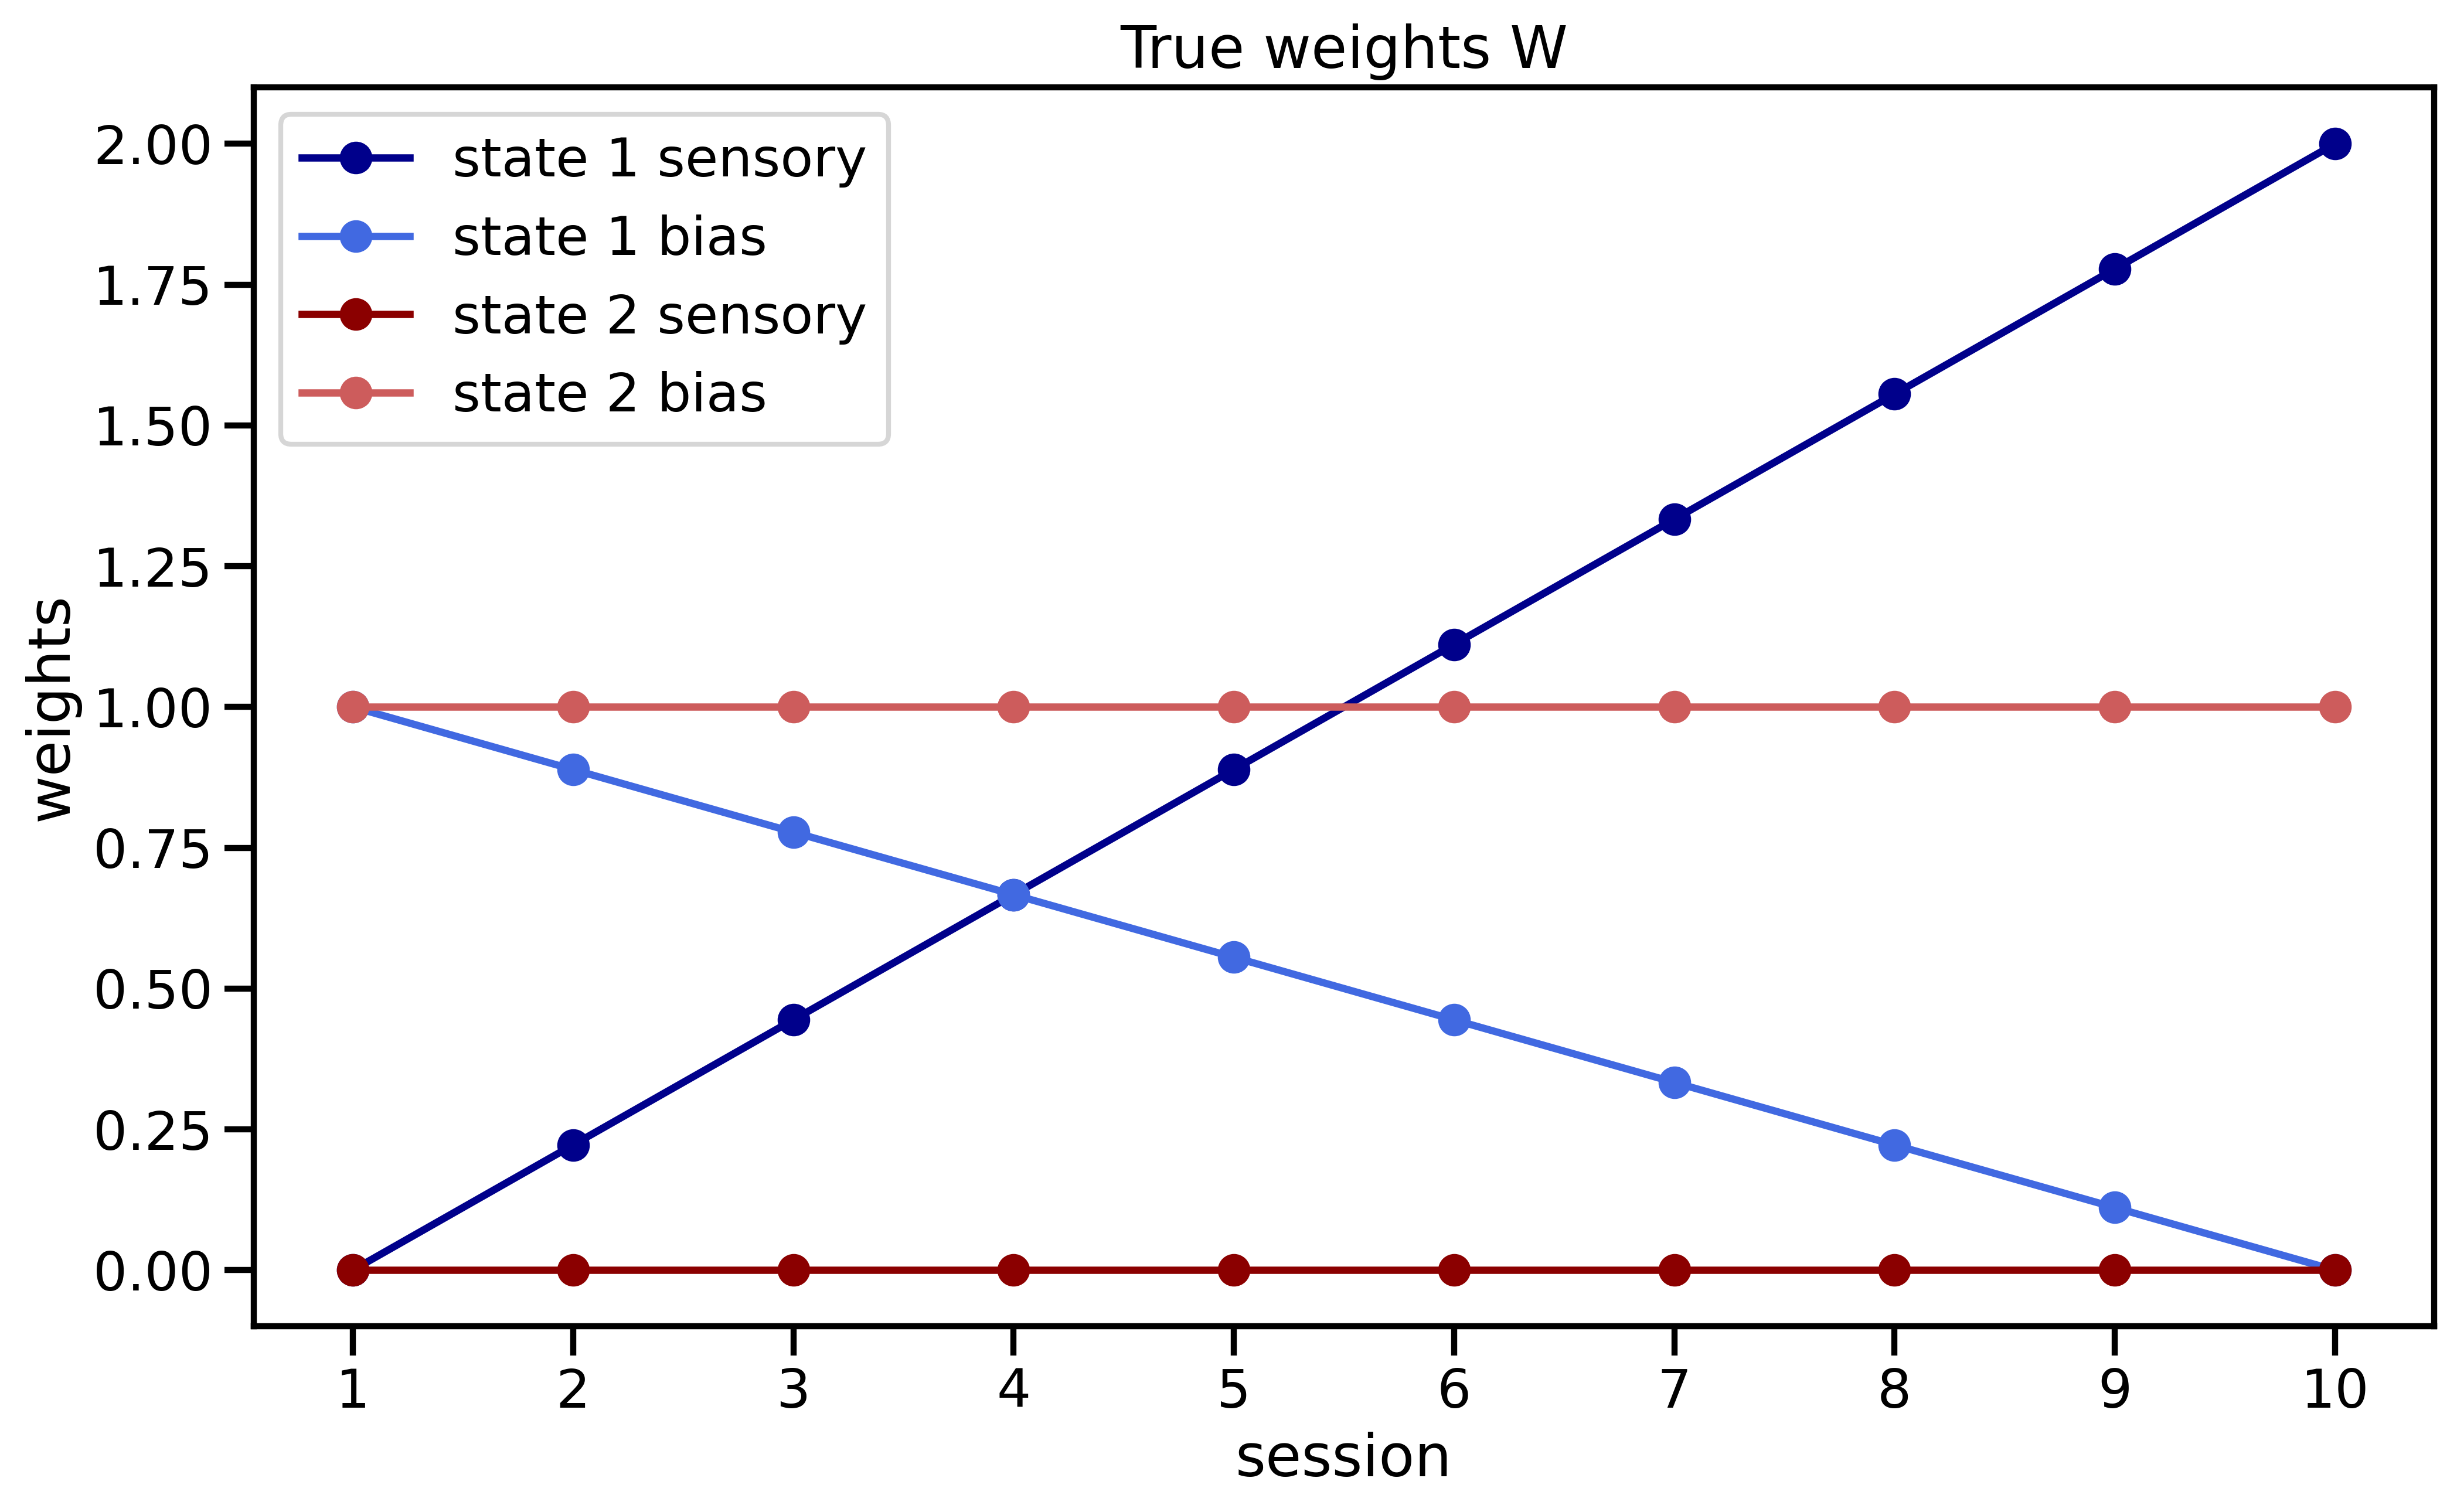

In [4]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)

testSessInd = []
for sess in range(0,S+1):
    testSessInd.append(sess*1000)

print(trueW.shape)
fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
plotting_weights(w=trueW, sessInd=sessInd, axes=axes, trueW=None, title='True weights W', save_fig=False)

In [5]:
dGLMHMM1 = dglm_hmm1.dGLM_HMM1(N,K,D,C)
dGLMHMM = dglm_hmm2.dGLM_HMM2(N,K,D,C)
#_, _, _ = dGLMHMM.simulate_data(trueW, trueP, sessInd, save=True, title=f'N={N}_{K}_state_constantP_train', pi0=0.5)
trainX = np.load(f'../data/N={N}_2_state_constantP_trainX.npy')
trainY = np.load(f'../data/N={N}_2_state_constantP_trainY.npy')
testX = np.load(f'../data/2_state_constantP_testX.npy') # N=50k
testY = np.load(f'../data/2_state_constantP_testY.npy') # N=50k
testSessInd = []
for sess in range(0,S+1):
    testSessInd.append(sess*5000)



In [38]:
oneSessInd = [0,N]
initP0, initW0 = dGLMHMM1.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initial random param
initP,  initW, _ = dGLMHMM1.fit(trainX, trainY,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=300, tol=1e-4) # GLM-HMM param # sigma does not matter
checkP0,  checkW0, _ = dGLMHMM1.fit(trainX, trainY,  initP, initW, sigma=reshapeSigma(0.2, K, D), sessInd=sessInd, pi0=None, maxIter=300, tol=1e-4) # dGLM-HMM1 
checkP, checkW, checkLl = dGLMHMM.fit(trainX, trainY,  initP=reshapeP_M1_to_M2(checkP0, N), initW=checkW0, sigma=reshapeSigma(0.2, K, D), alpha=1, globalP=checkP0, sessInd=sessInd, pi0=None, maxIter=600, tol=1e-3) # fit the model
# checkP, checkW, checkLl = dGLMHMM.fit(trainX, trainY,  initP=reshapeP_M1_to_M2(initP, N), initW=initW, sigma=reshapeSigma(0.2, K, D), sessInd=sessInd, pi0=None, maxIter=600, tol=1e-3) # fit the model

# 7-11 minutes with L-BFGS-S; 48 min for T=5000
# 24 minutes with BFGS


0


KeyboardInterrupt: 

In [57]:
print("Global P used for Dirichlet Prior and found by fitting dGLM-HMM version 1")
print(checkP0)

Global P used for Dirichlet Prior and found by fitting dGLM-HMM version 1
[[0.95957491 0.04042509]
 [0.04858445 0.95141555]]


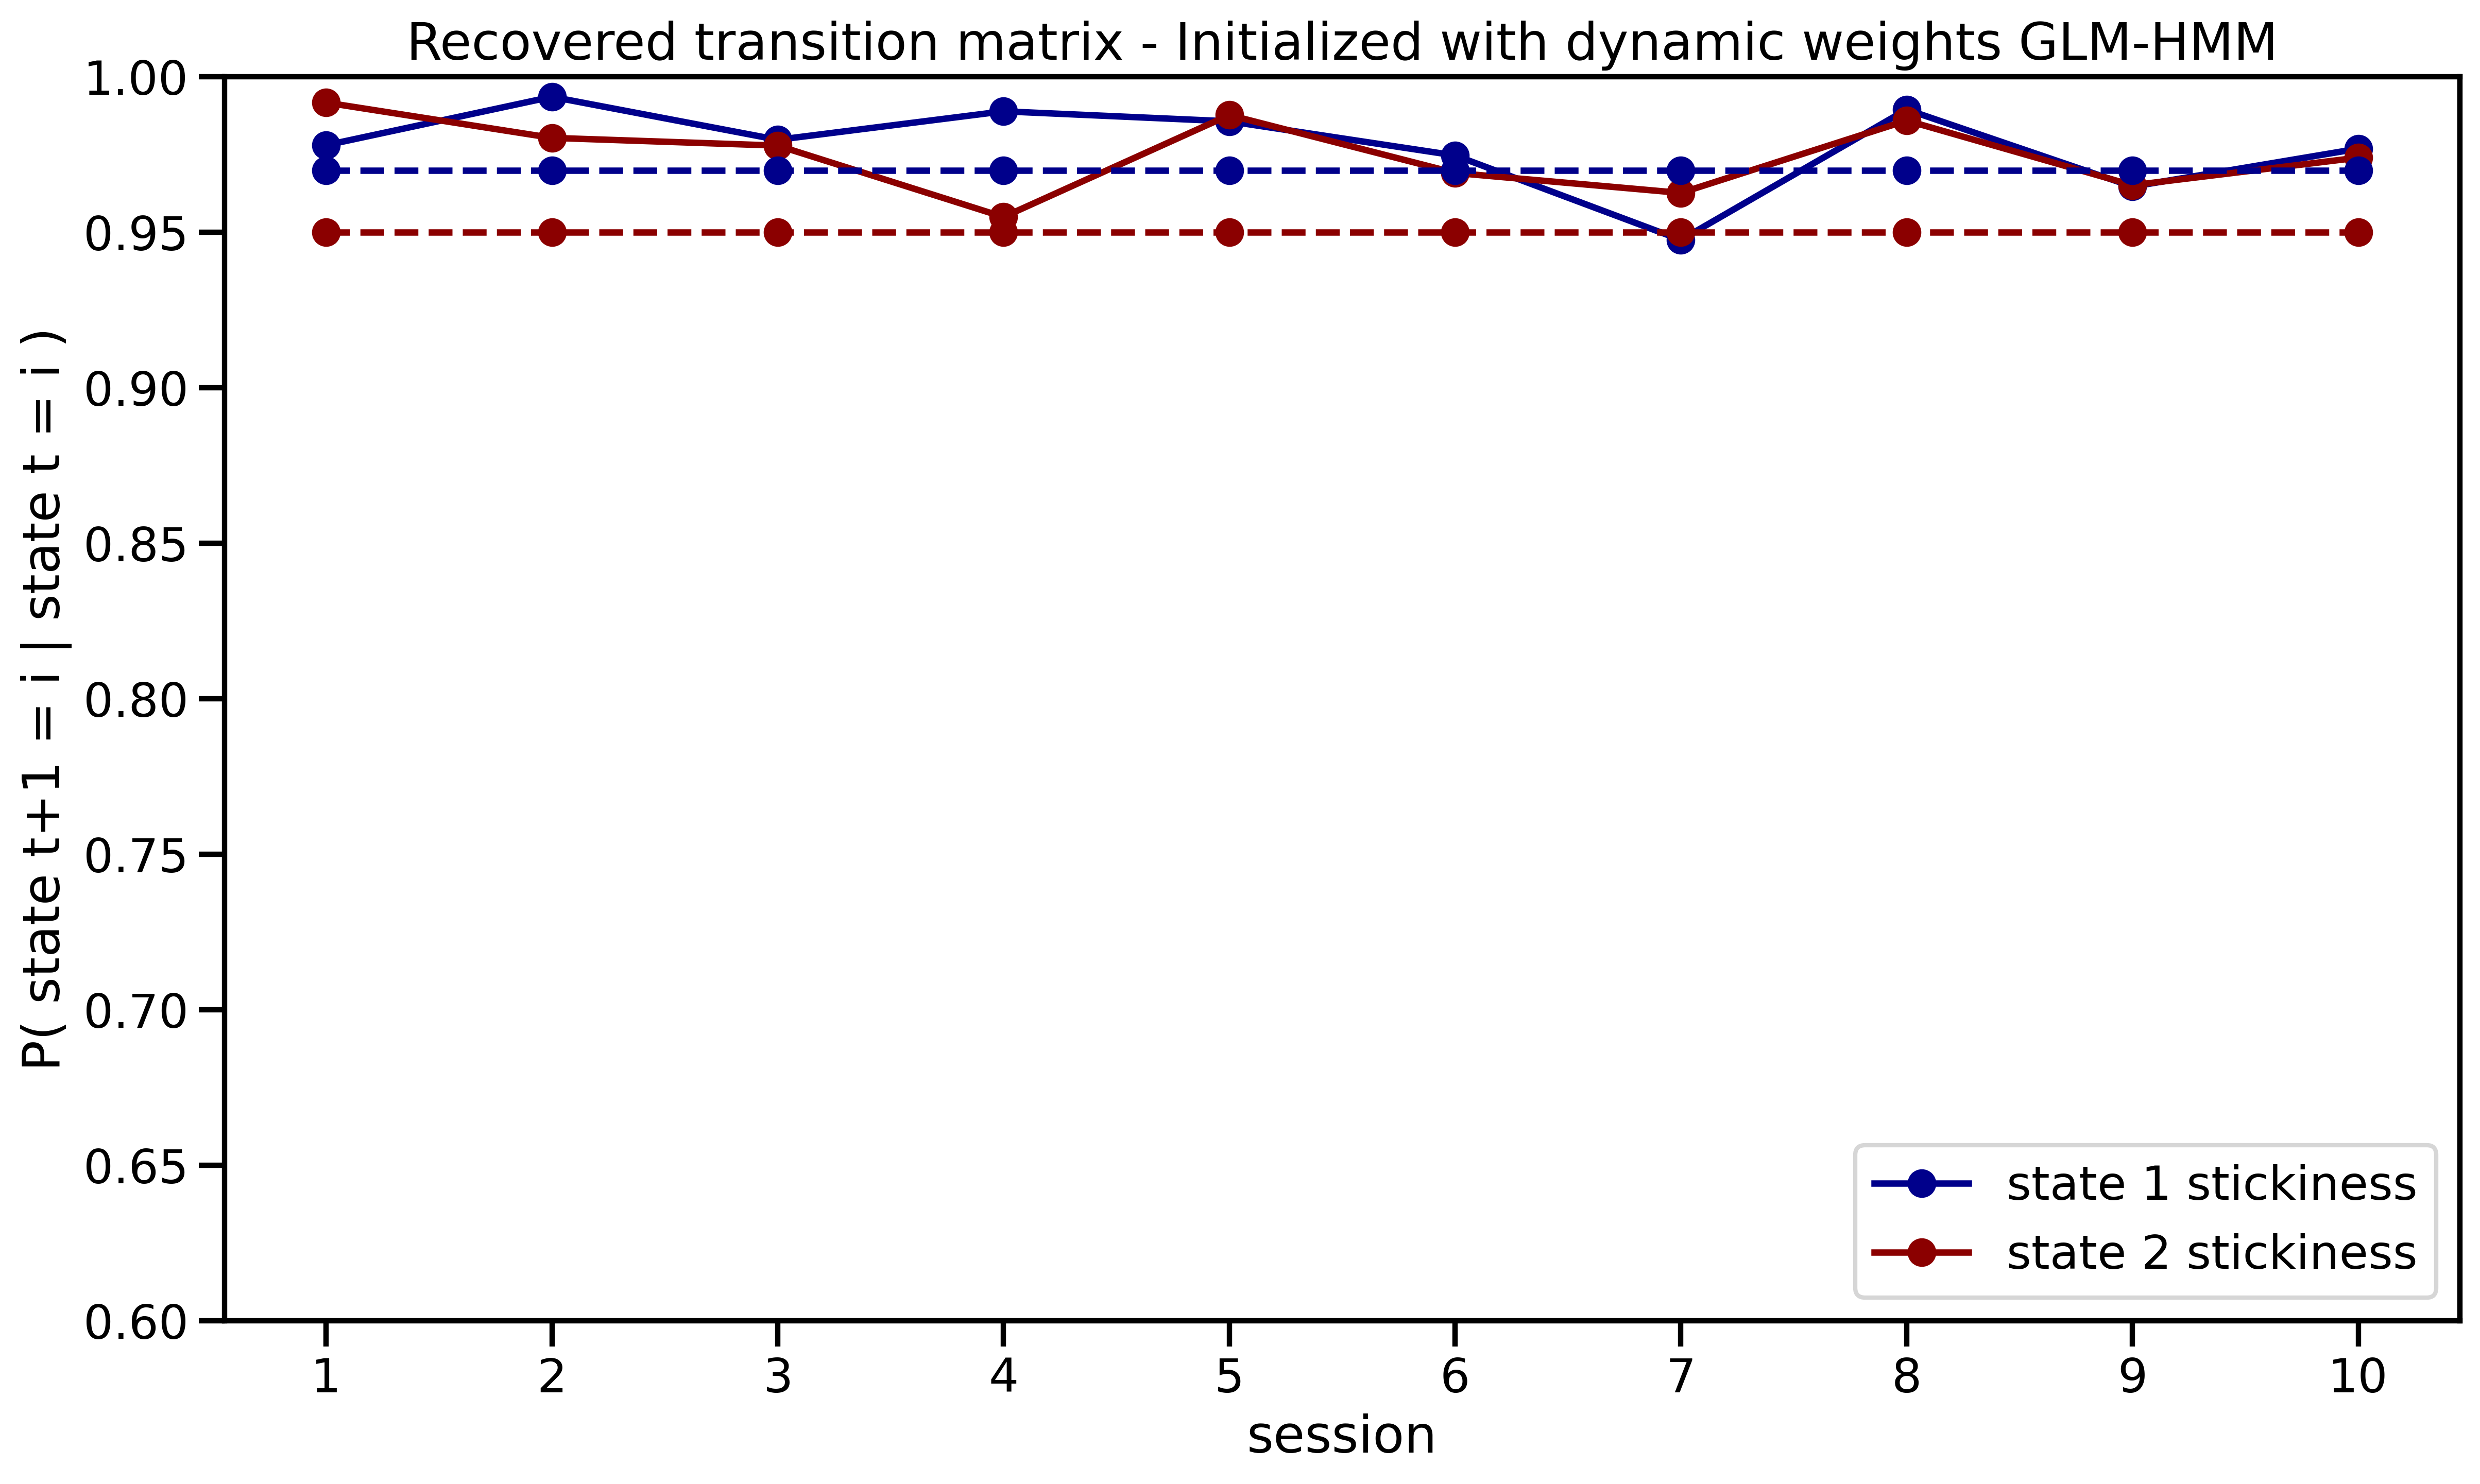

In [12]:
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_transition_matrix_stickiness(checkP, sessInd, axes, trueP=trueP, title='Recovered transition matrix - Initialized with dynamic weights GLM-HMM', save_fig=False)

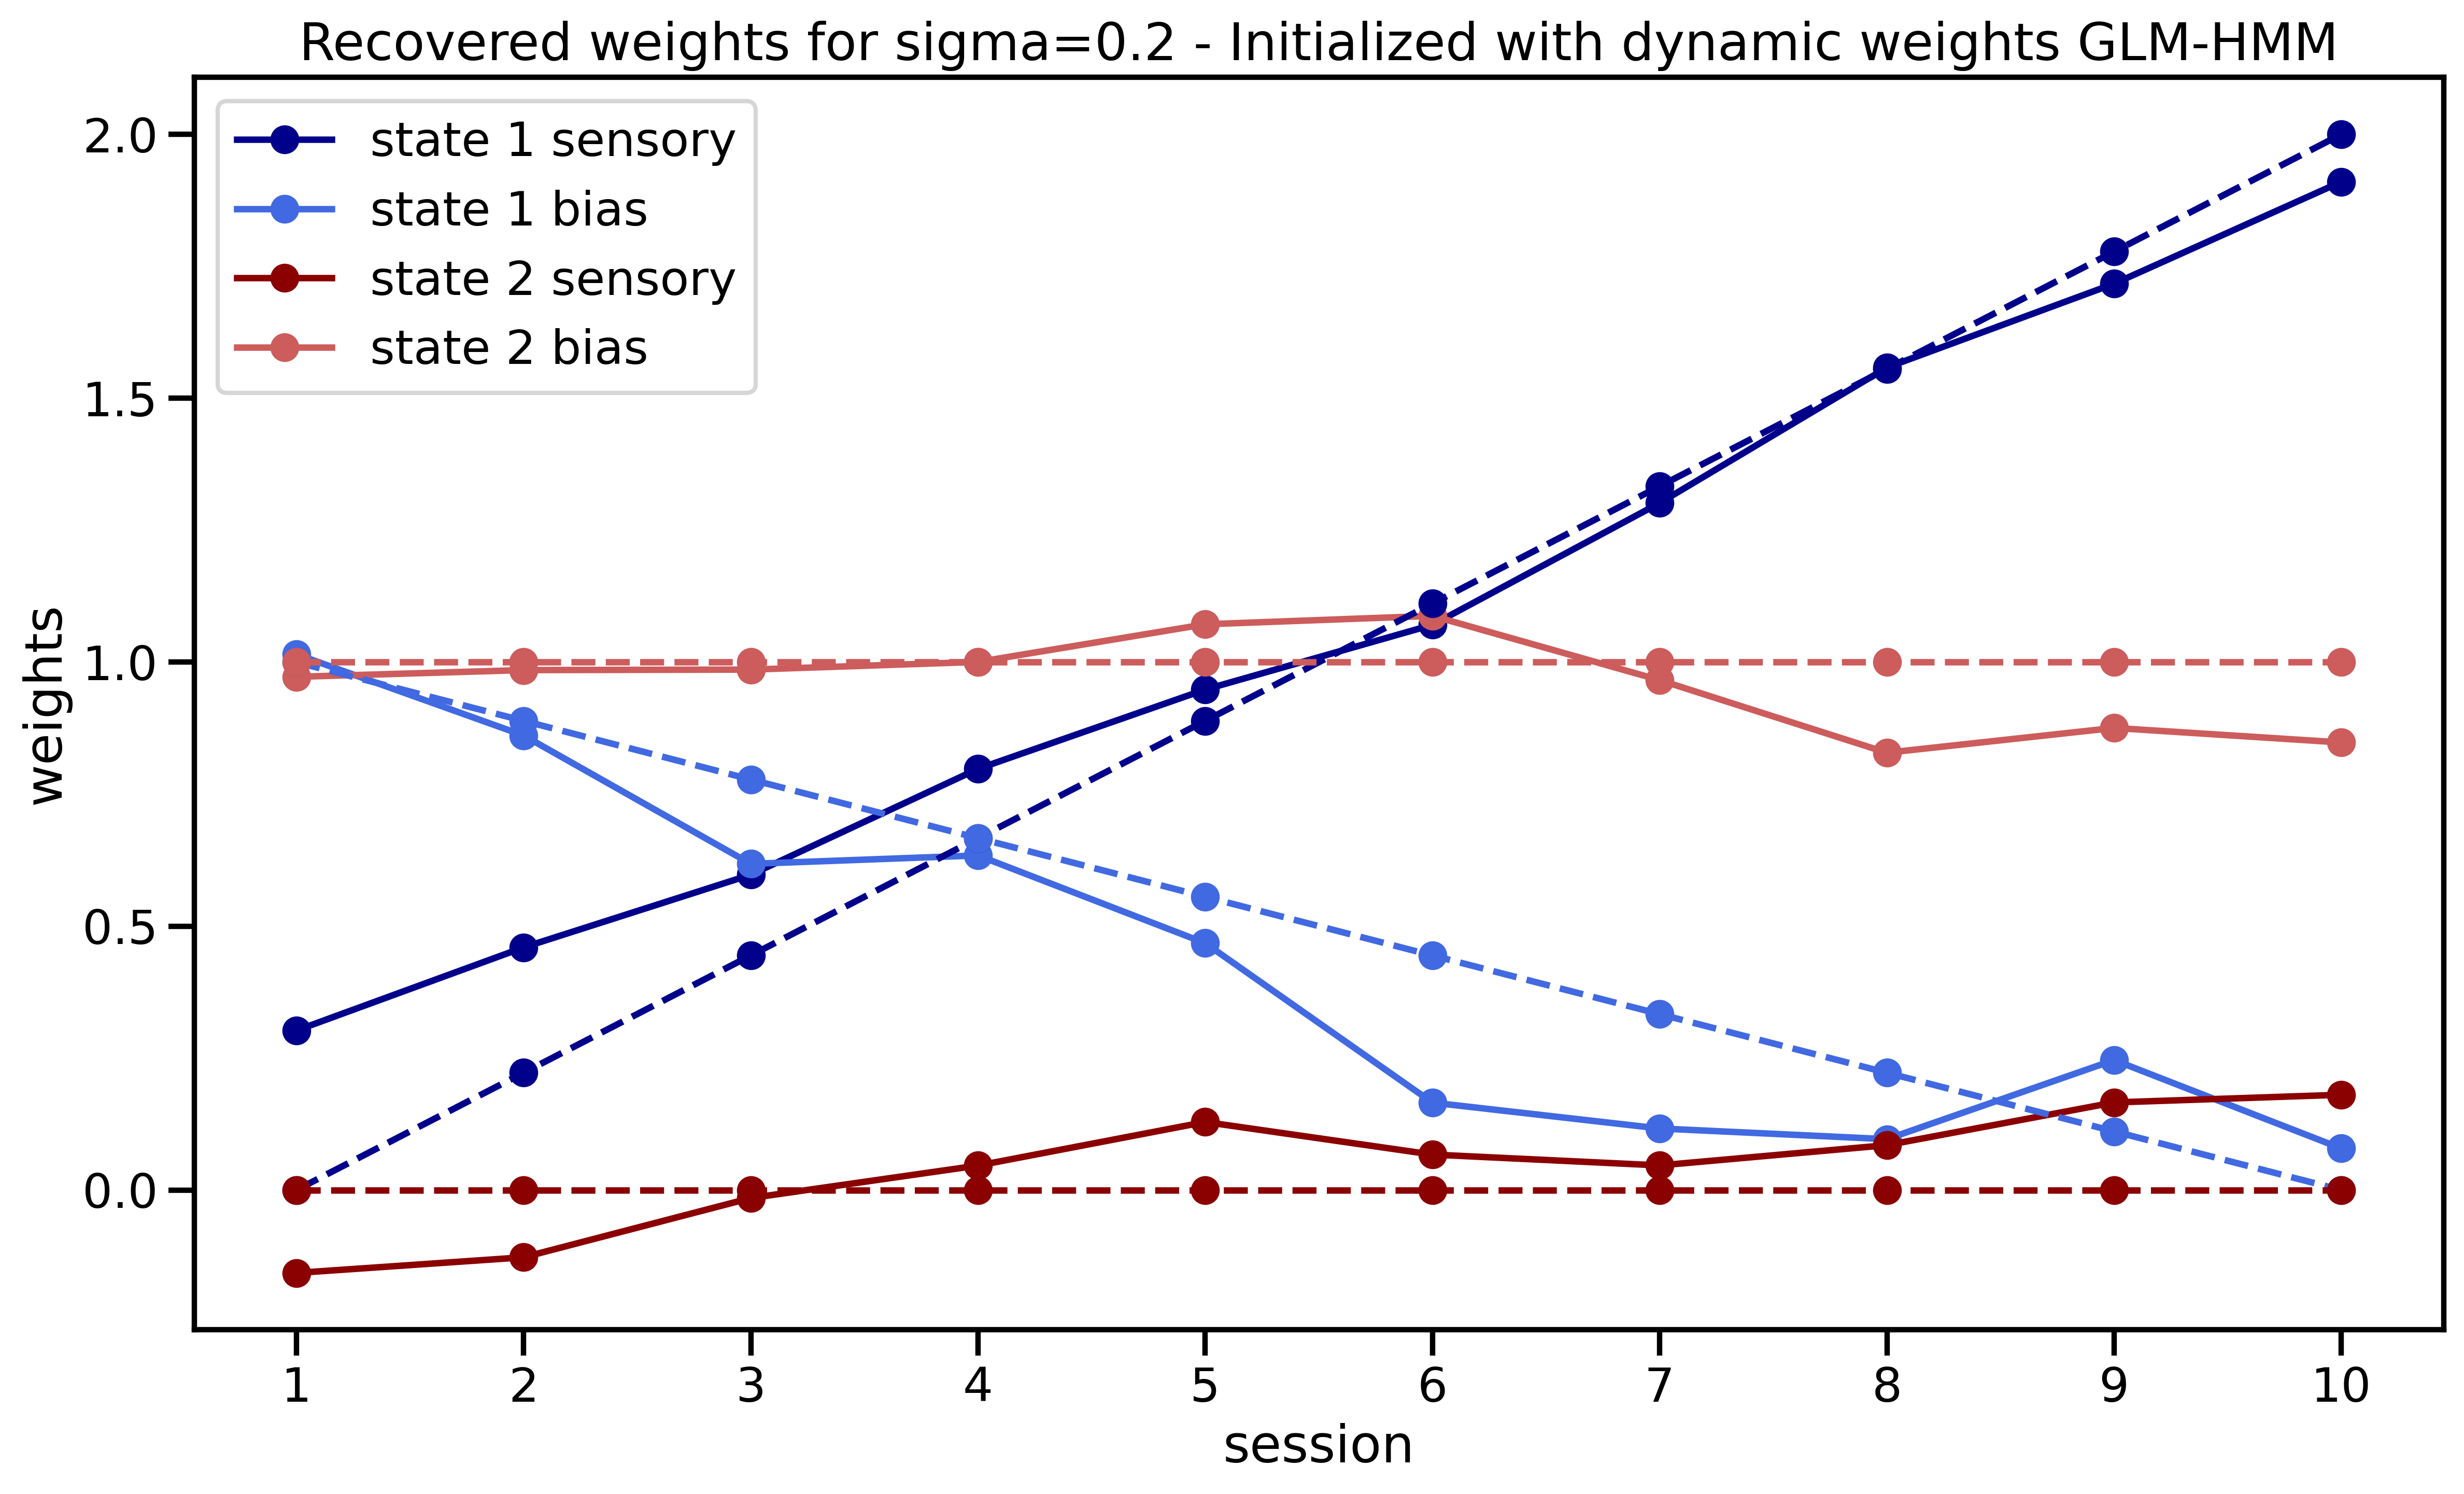

In [13]:
# fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
# plotting_weights(checkW0, sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma=0.2', save_fig=False)
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_weights(checkW, sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma=0.2 - Initialized with dynamic weights GLM-HMM', save_fig=False)

In [54]:
# Fitting for different values of alpha
alphaList = [4**x for x in list(np.arange(0.5,5,0.5, dtype=float))]
maxiter=600
allLl = np.zeros((len(alphaList),maxiter))
allP = np.zeros((len(alphaList),N,K,K))
allW = np.zeros((len(alphaList),N,K,D,C))
testLl = np.zeros((len(alphaList)))

oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
# initP0, initW0 = dGLMHMM1.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initial random param
# initP,  initW, _ = dGLMHMM1.fit(trainX, trainY,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-4) # GLM-HMM param # sigma does not matter
# checkP0,  checkW0, _ = dGLMHMM1.fit(trainX, trainY,  initP, initW, sigma=reshapeSigma(0.2, K, D), sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-4) # dGLM-HMM1 
# print("Global P")
# print(checkP0)
for indAlpha in range(0,len(alphaList)): 
    print(f'indAlpha {indAlpha}')
    if (indAlpha == 0):
    # fit
        allP[indAlpha],allW[indAlpha], allLl[indAlpha] = dGLMHMM.fit(trainX, trainY,  initP=reshapeP_M1_to_M2(checkP0, N), initW=checkW0, sigma=reshapeSigma(0.2, K, D), alpha=alphaList[indAlpha], globalP=checkP0, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
    else:
        allP[indAlpha],allW[indAlpha], allLl[indAlpha] = dGLMHMM.fit(trainX, trainY,  initP=allP[indAlpha-1], initW=allW[indAlpha-1], sigma=reshapeSigma(0.2, K, D), alpha=alphaList[indAlpha], globalP=checkP0, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
    
   # evaluate
    testPhi = dGLMHMM.observation_probability(testX, reshapeWeights(allW[indAlpha], sessInd, testSessInd))
    for s in range(0, S):
        _, _, temp = dGLMHMM.forward_pass(testY[testSessInd[s]:testSessInd[s+1]],allP[indAlpha],testPhi[testSessInd[s]:testSessInd[s+1]])
        testLl[indAlpha] += temp
   
testLl = testLl / testSessInd[-1] # normalizing to the total number of trials in test
    
np.save(f'../data/Ll_N={N}_{K}_state_constantP_consecFitting', allLl)
np.save(f'../data/P_N={N}_{K}_state_constantP_consecFitting', allP)
np.save(f'../data/W_N={N}_{K}_state_constantP_consecFitting', allW)
np.save(f'../data/testLl_N={N}_{K}_state_constantP_consecFitting', testLl)

indAlpha 0
0
10
indAlpha 1
0
10
indAlpha 2
0
10
indAlpha 3
0
10
indAlpha 4
0
10
20
30
40
50
60
70
indAlpha 5
0
10
20
30
indAlpha 6
0
10
indAlpha 7
0
10
indAlpha 8
0
10


In [55]:
print("Global P")
print(checkP0)
print(N)

Global P
[[0.97335595 0.02664405]
 [0.04718291 0.95281709]]
50000


In [7]:
# Fitting for different values of alpha
# alphaList = [4**x for x in list(np.arange(-3,2, dtype=float))] + [4**x for x in list(np.arange(2,5,0.5, dtype=float))] + [4**x for x in list(np.arange(5,9,1, dtype=float))]
alphaList = [4**x for x in [-3,-1,1,3,4,5,7,9]]
maxiter=600
allLl = np.zeros((len(alphaList),maxiter))
allP = np.zeros((len(alphaList),N,K,K))
allW = np.zeros((len(alphaList),N,K,D,C))
testLl = np.zeros((len(alphaList)))

oneSessInd = [0,N] # treating whole dataset as one session for normal GLM-HMM fitting
initP0, initW0 = dGLMHMM1.generate_param(sessInd=oneSessInd, transitionDistribution=['dirichlet', (5, 1)], weightDistribution=['uniform', (-2,2)]) # initial random param
initP,  initW, _ = dGLMHMM1.fit(trainX, trainY,  initP0, initW0, sigma=reshapeSigma(1, K, D), sessInd=oneSessInd, pi0=None, maxIter=maxiter, tol=1e-4) # GLM-HMM param # sigma does not matter
checkP0,  checkW0, _ = dGLMHMM1.fit(trainX, trainY,  initP, initW, sigma=reshapeSigma(0.2, K, D), sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-4) # dGLM-HMM1 
    
for indAlpha in range(0,len(alphaList)): 
   print(f'indAlpha {indAlpha}')

   # fit
   allP[indAlpha],allW[indAlpha], allLl[indAlpha] = dGLMHMM.fit(trainX, trainY,  initP=reshapeP_M1_to_M2(checkP0, N), initW=checkW0, sigma=reshapeSigma(0.2, K, D), alpha=alphaList[indAlpha], globalP=checkP0, sessInd=sessInd, pi0=None, maxIter=maxiter, tol=1e-3) # fit the model
   
   # evaluate
   testPhi = dGLMHMM.observation_probability(testX, reshapeWeights(allW[indAlpha], sessInd, testSessInd))
   for s in range(0, S):
      _, _, temp = dGLMHMM.forward_pass(testY[testSessInd[s]:testSessInd[s+1]],allP[indAlpha],testPhi[testSessInd[s]:testSessInd[s+1]])
      testLl[indAlpha] += temp
   
testLl = testLl / testSessInd[-1] # normalizing to the total number of trials in test
    
np.save(f'../data/Ll_N={N}_{K}_state_constantP', allLl)
np.save(f'../data/P_N={N}_{K}_state_constantP', allP)
np.save(f'../data/W_N={N}_{K}_state_constantP', allW)
np.save(f'../data/testLl_N={N}_{K}_state_constantP', testLl)


0
10
20
30
40
50
60
70
0
10
20
30
40
50
60
indAlpha 0
0
10
indAlpha 1
0
10
indAlpha 2
0
10
indAlpha 3
0
10
20
30
indAlpha 4
0
10
20
30
indAlpha 5
0
10
indAlpha 6
0
10
indAlpha 7
0
10


In [36]:
# oldW = np.load('../data/W_N=50000_2_state_constantP.npy')
# oldP = np.load('../data/P_N=50000_2_state_constantP.npy')
# oldLl = np.load('../data/testLl_N=50000_2_state_constantP.npy')
# alphaList = [4**x for x in list(np.arange(-3,2, dtype=float))] + [4**x for x in list(np.arange(2,4,0.25, dtype=float))] + [4**x for x in list(np.arange(4,8,1, dtype=float))]
# print(oldW.shape)

oldW = np.load('../data/W_N=50000_2_state_constantP_alphaV2.npy')
oldP = np.load('../data/P_N=50000_2_state_constantP_alphaV2.npy')
oldLl = np.load('../data/testLl_N=50000_2_state_constantP_alphaV2.npy')
alphaList = [4**x for x in [-3,-1,1,3,4,5,7,9]]
print(oldW.shape)

(8, 50000, 2, 2, 2)


In [13]:
print(checkP0)
print(testLl)

NameError: name 'checkP0' is not defined

Text(0.5, 1.0, 'Model performance as a function of hyperparameter alpha')

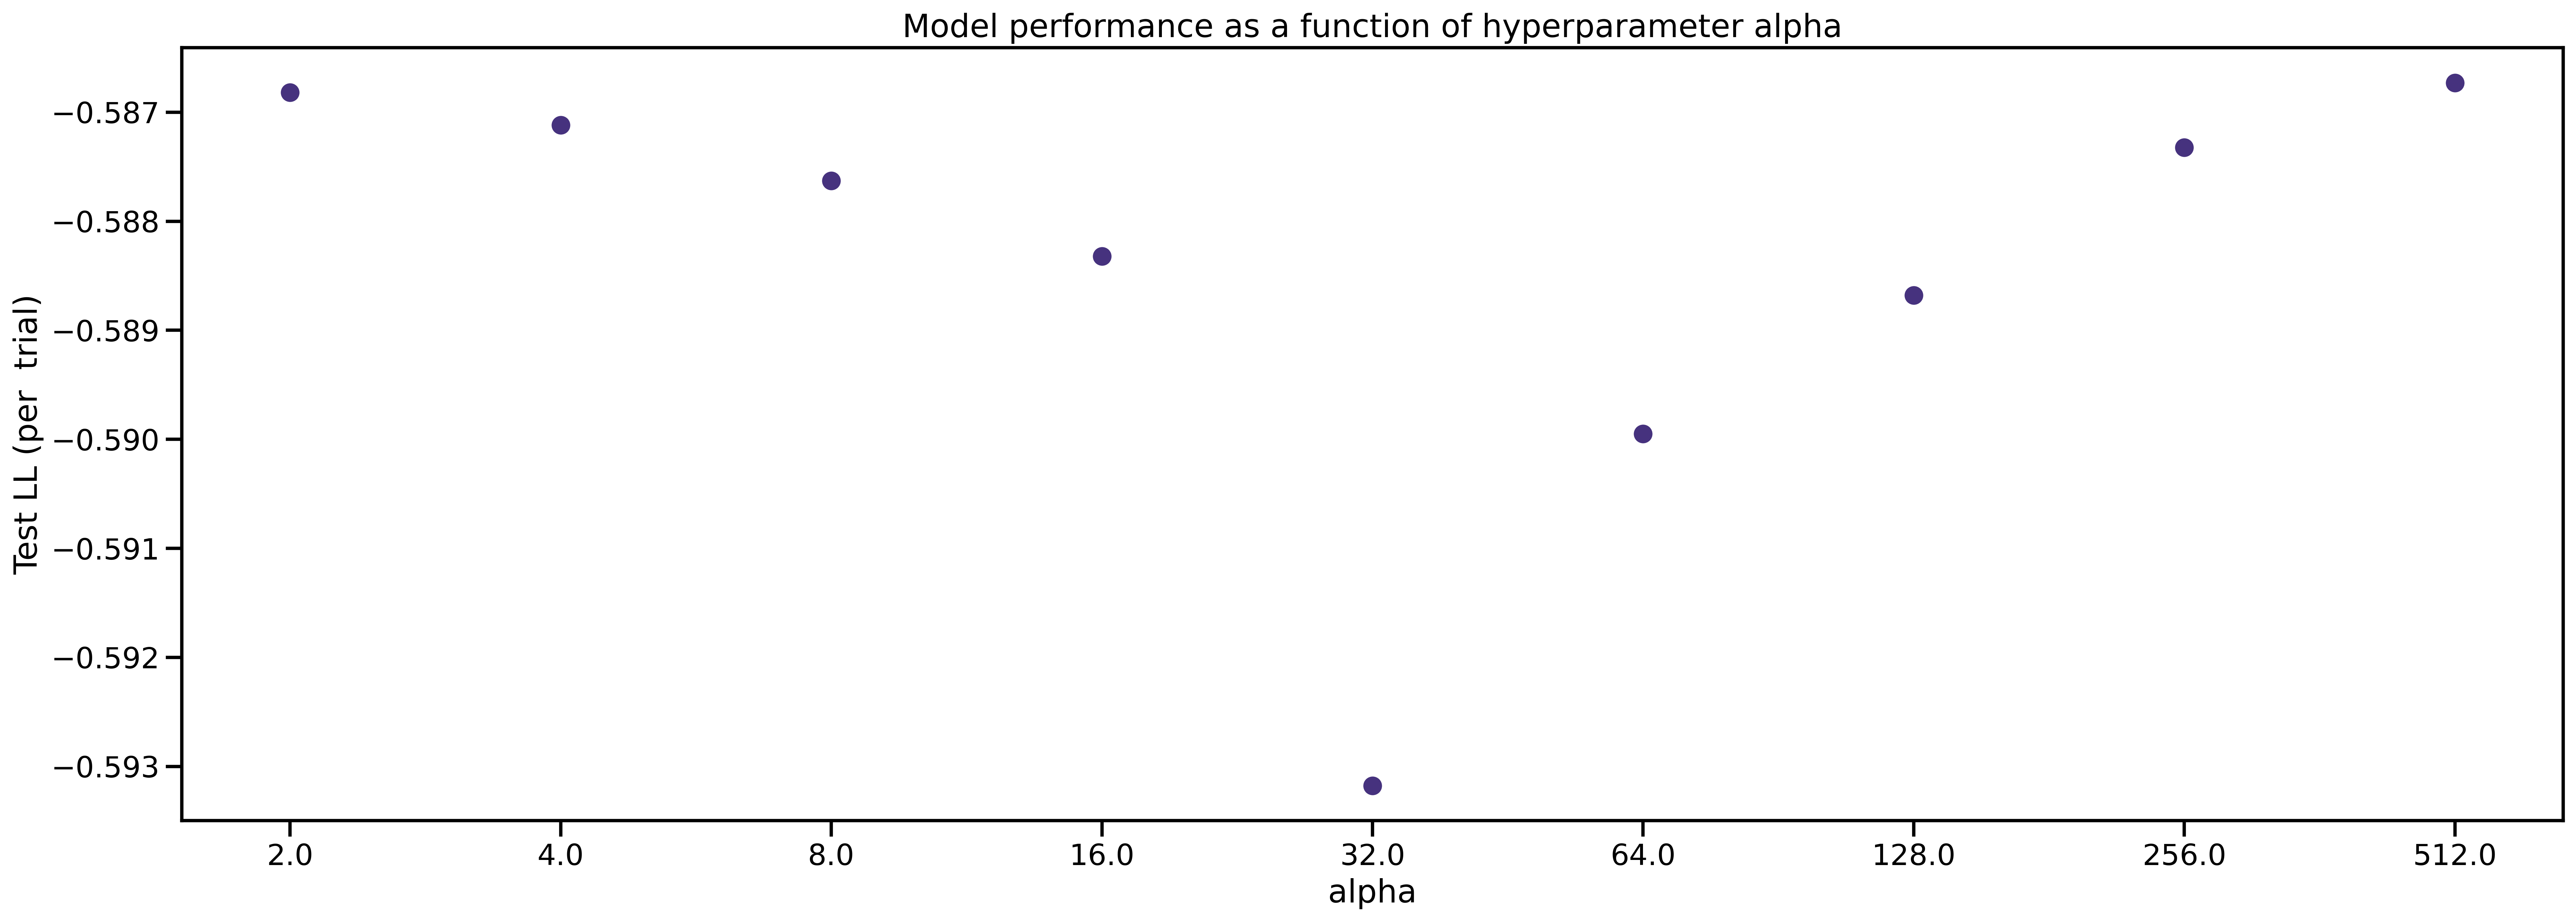

In [63]:
fig, axes = plt.subplots(1, figsize = (24,8), dpi=400)
colormap = sns.color_palette("viridis")
axes.scatter(np.log2(alphaList), testLl[:], color = colormap[0])
axes.set_xlabel('alpha')
axes.set_ylabel('Test LL (per  trial)')
# alphaListEven = [alphaList[ind] for ind in range(0,len(alphaList),2)]
# axes.set_xticks(np.log2(alphaListEven),[f'{np.round(alpha,1)}' for alpha in alphaListEven])
axes.set_xticks(np.log2(alphaList),[f'{np.round(alpha,1)}' for alpha in alphaList])
axes.set_title('Model performance as a function of hyperparameter alpha')
#fig.savefig(f'../figures/Alpha_vs_TestLl-version1.png', bbox_inches='tight', dpi=400)

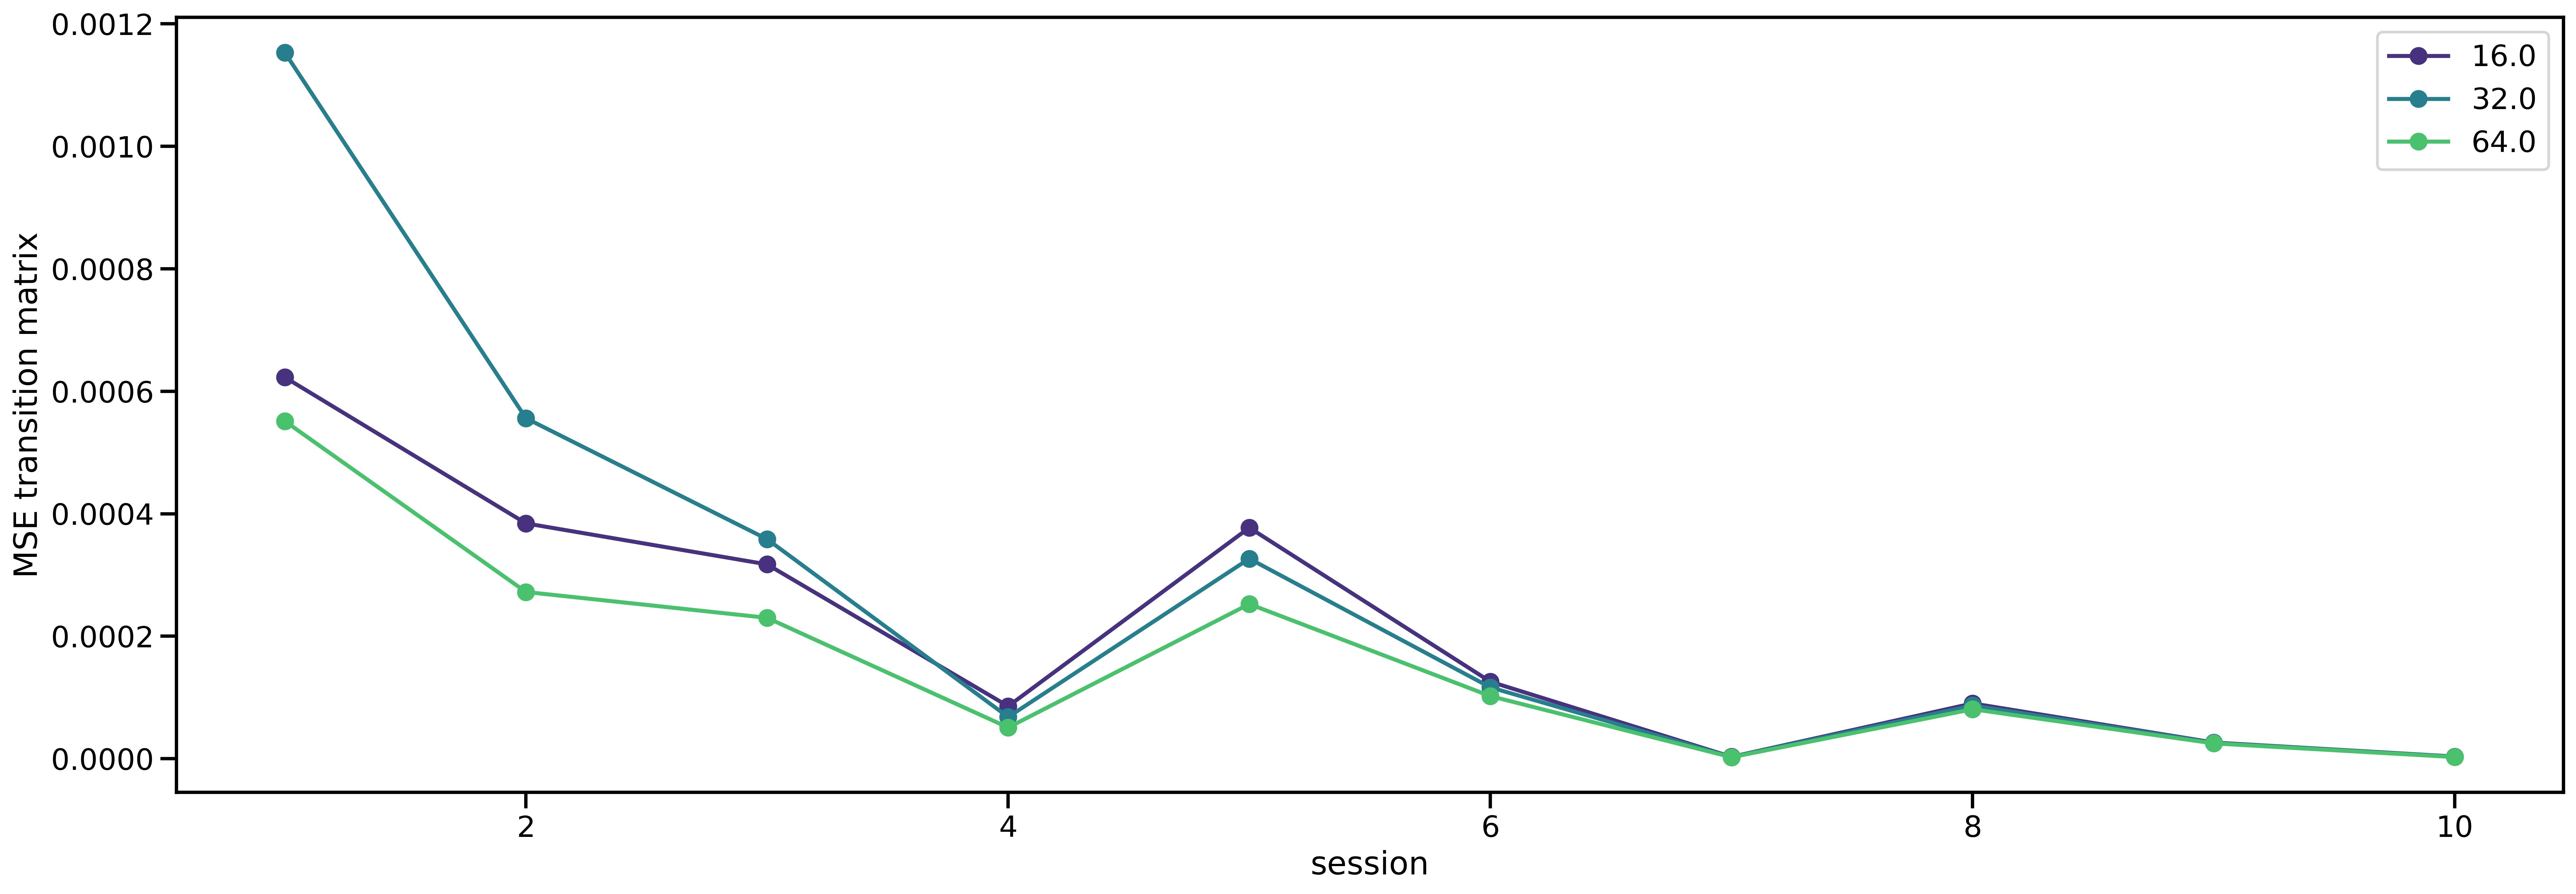

In [81]:
mseP = np.zeros((len(alphaList),len(sessInd)-1))
colormap = sns.color_palette("viridis")
fig, axes = plt.subplots(1, figsize = (24,8), dpi=400)
for indAlpha in [3,4,5]:#range(3,len(alphaList)-2):
    for s in range(0,len(sessInd)-1):
        mseP[indAlpha,s] = ((allP[indAlpha,sessInd[s]] - trueP[sessInd[s]])**2).mean(axis=None)
    axes.plot(range(1,sess+1),mseP[indAlpha],color=colormap[(indAlpha-3)*2],marker='o',label=f'{np.round(alphaList[indAlpha],1)}')
axes.set_ylabel('MSE transition matrix')
axes.set_xlabel('session')
axes.legend()

In [11]:
# fig, axes = plt.subplots(1, figsize = (24,8), dpi=400)
# colormap = sns.color_palette("viridis")
# axes.scatter(alphaList[:-3], testLl[:-3], color = colormap[0])
# axes.set_ylabel('np.log(alpha)')
# axes.set_ylabel('Test LL (per  trial)')
# alphaListEven = [alphaList[ind] for ind in range(0,len(alphaList),2)]
# axes.set_title('Model performance as a function of hyperparameter alpha')
# #fig.savefig(f'../figures/Alpha_vs_TestLl-version1.png', bbox_inches='tight', dpi=400)

In [12]:
# allW = np.load('../data/W_N=50000_2_state_constantP.npy')
# allP = np.load('../data/P_N=50000_2_state_constantP.npy')
print(allW.shape)
print(allP.shape)

(8, 50000, 2, 2, 2)
(8, 50000, 2, 2)


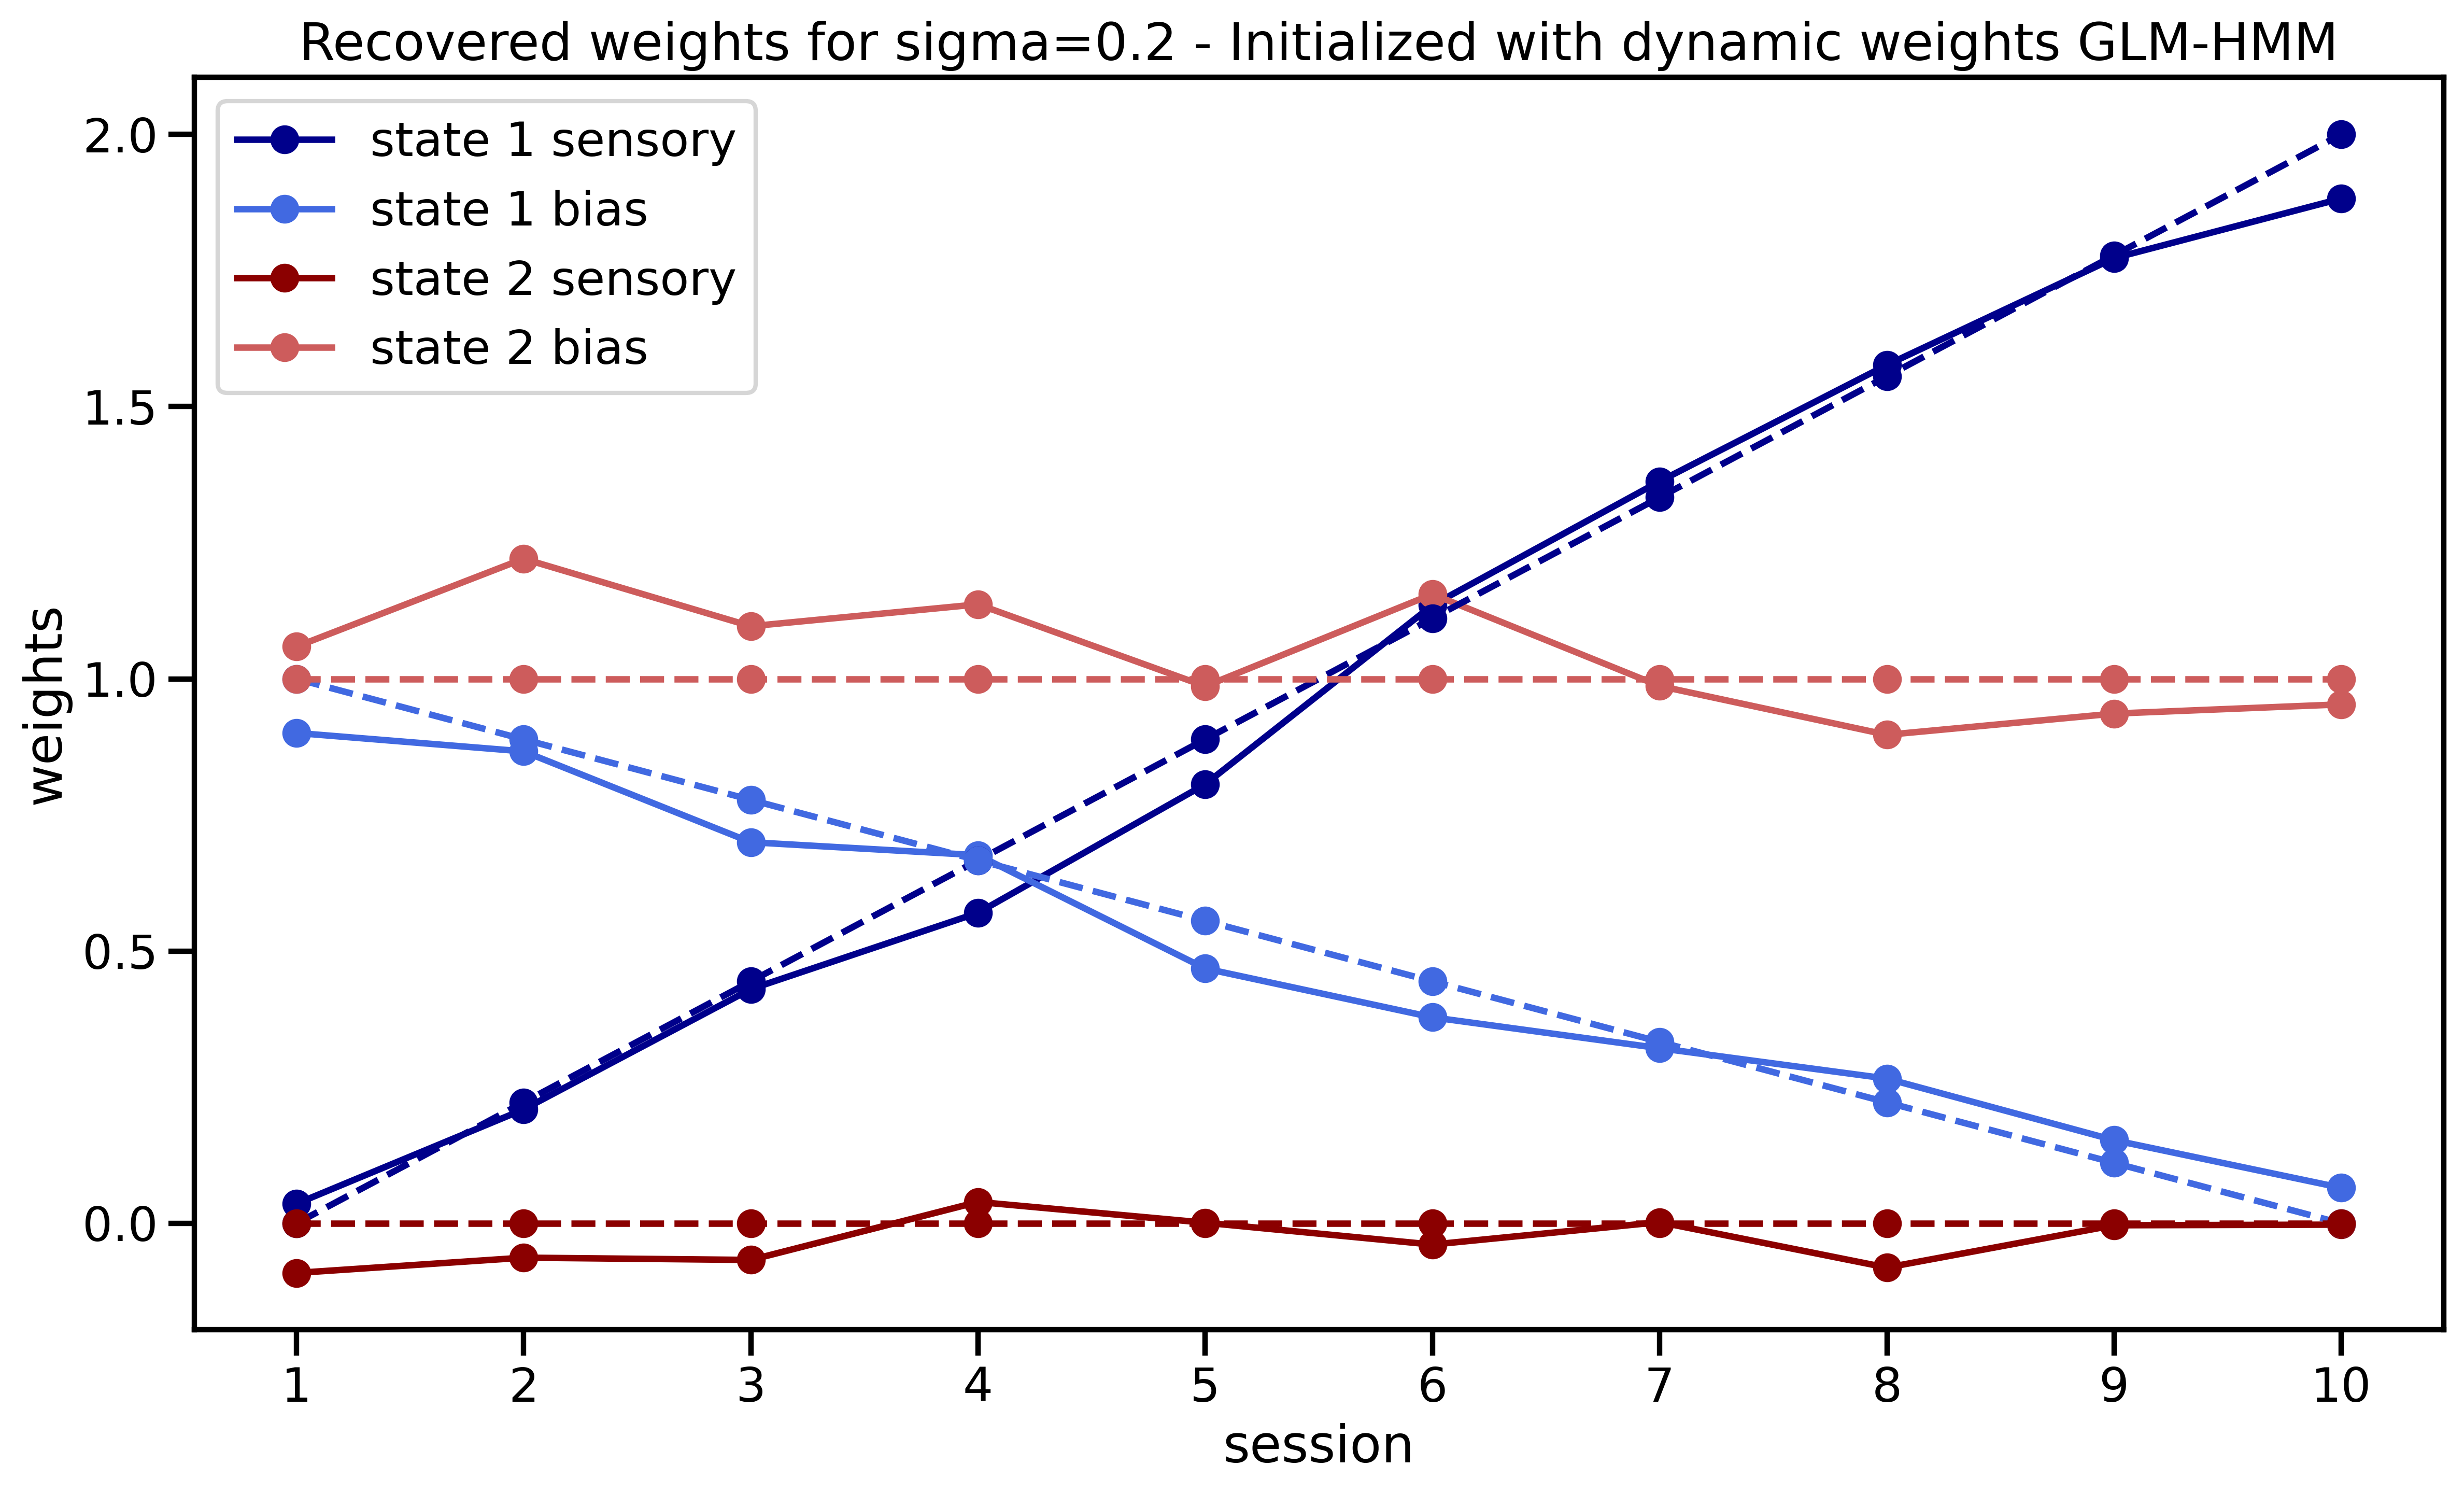

In [13]:
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_weights(checkW0, sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma=0.2 - Initialized with dynamic weights GLM-HMM', save_fig=False)
    

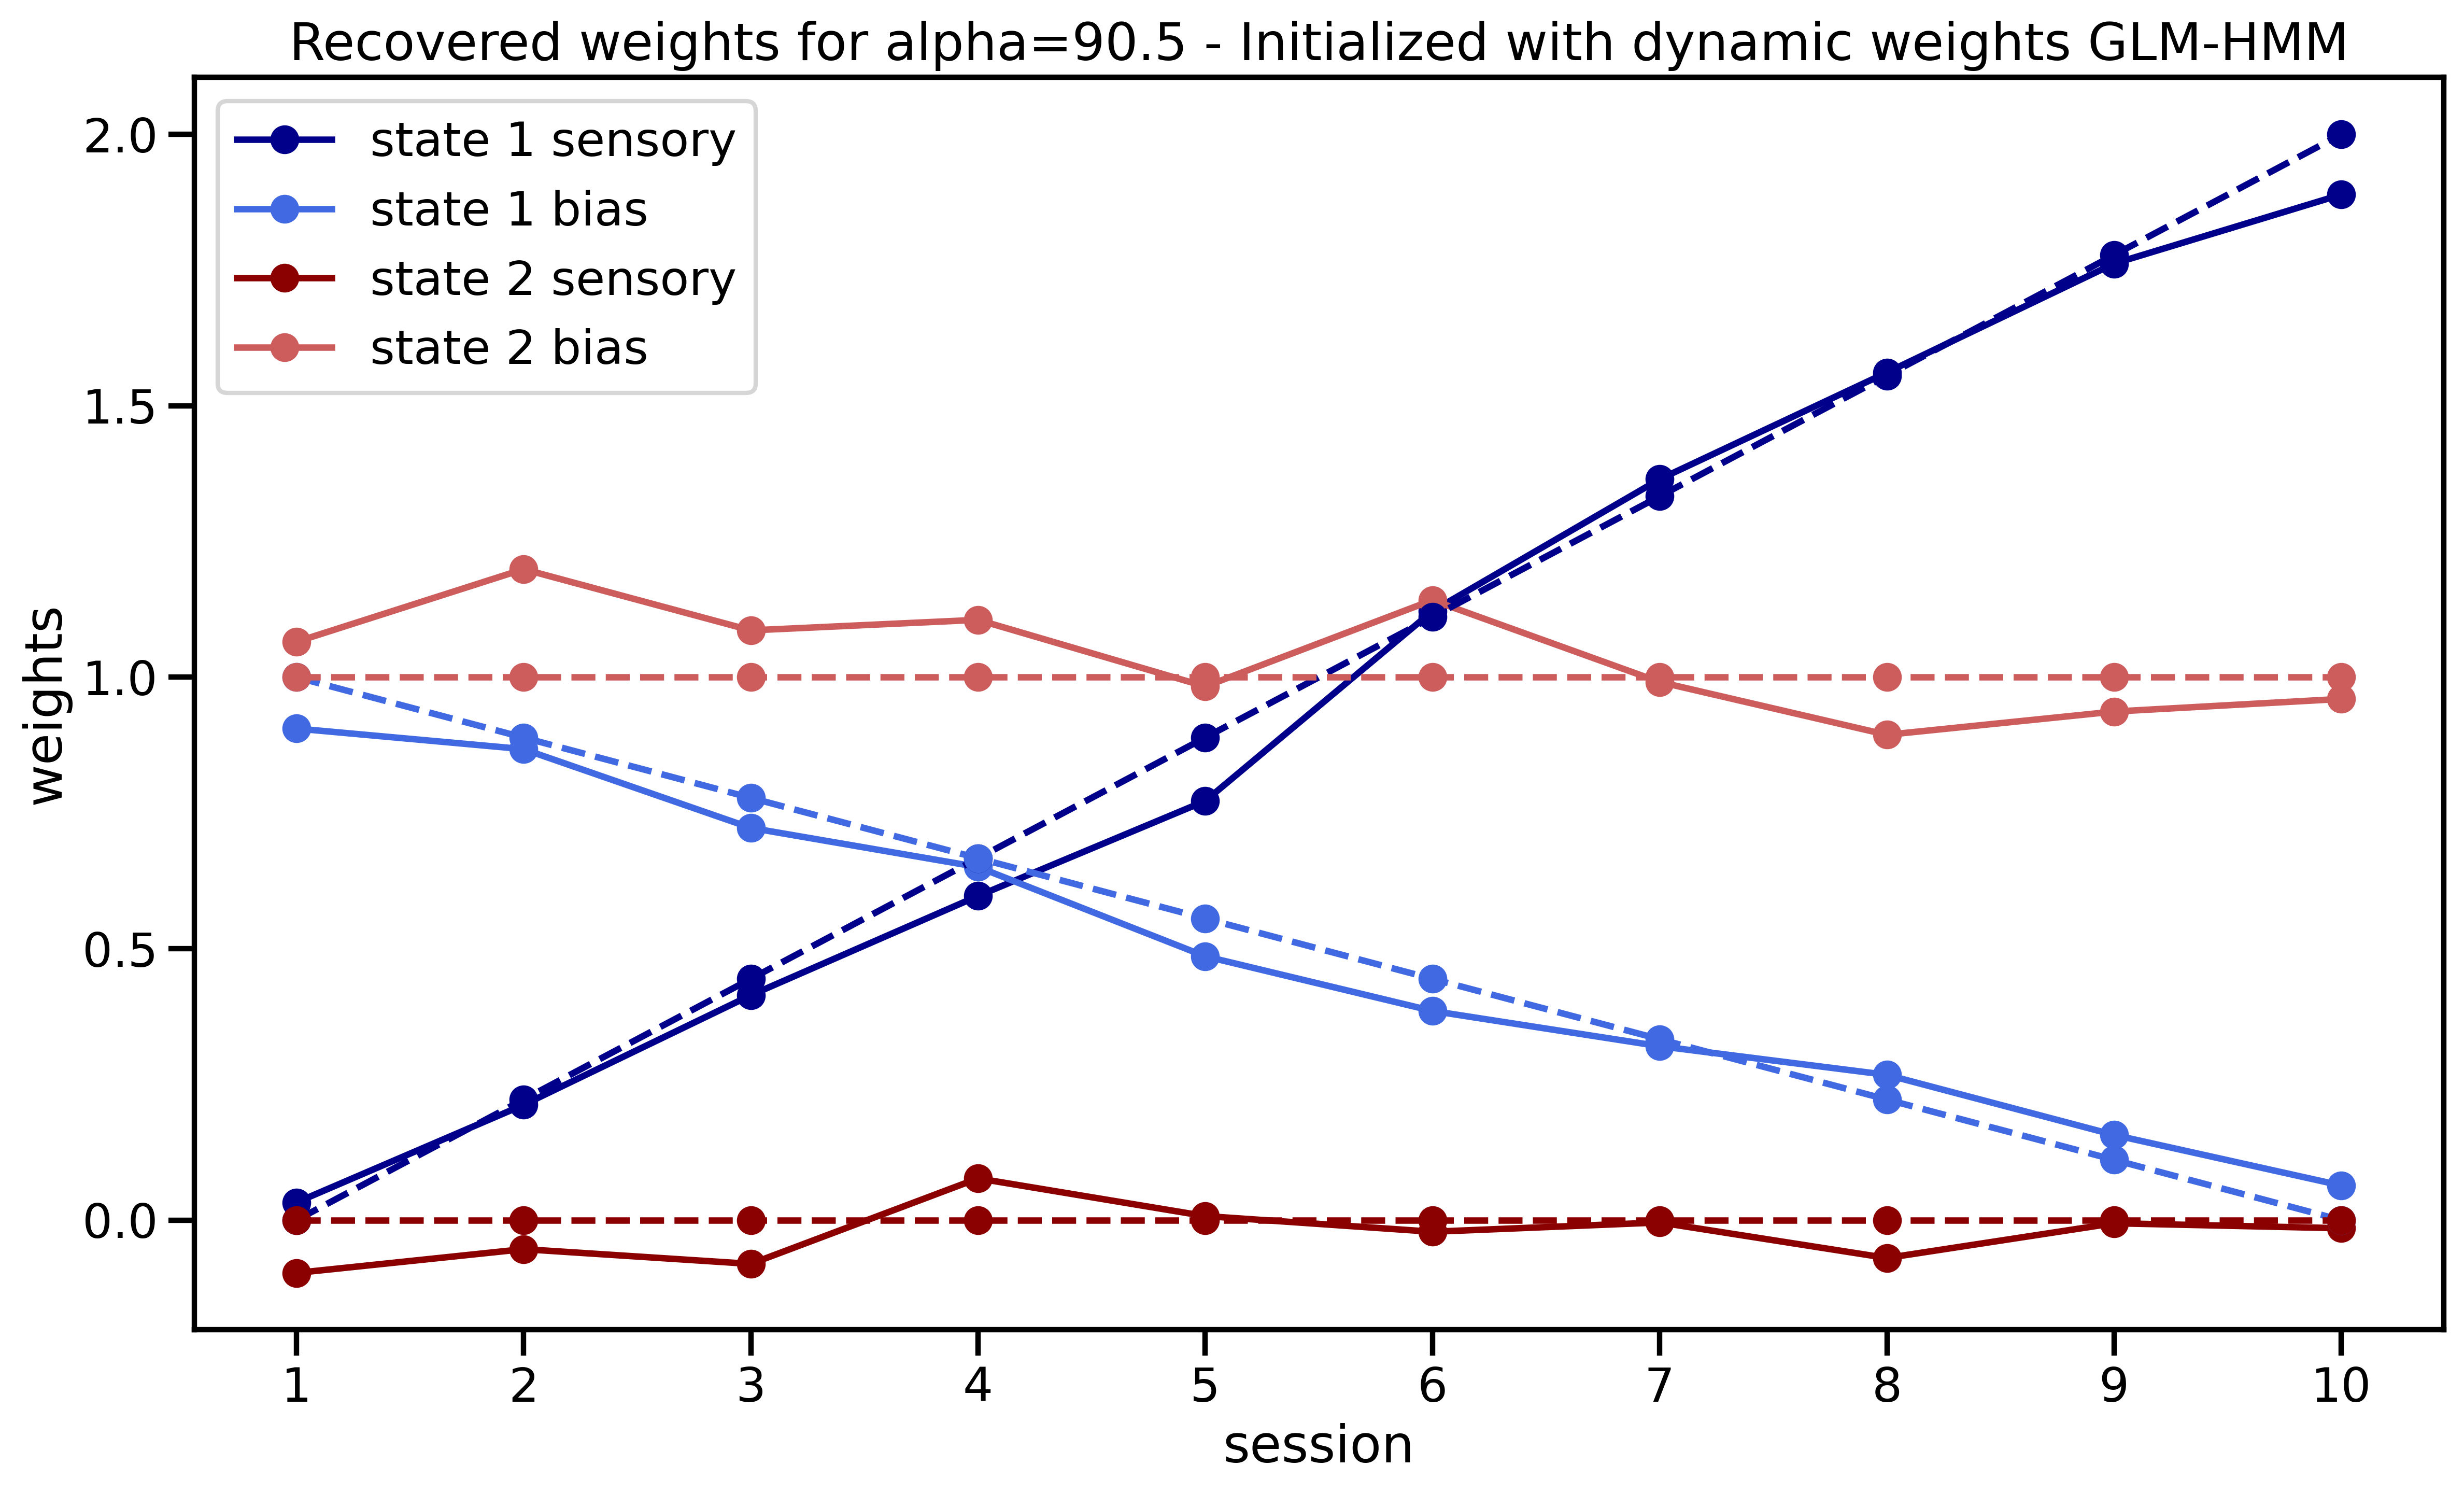

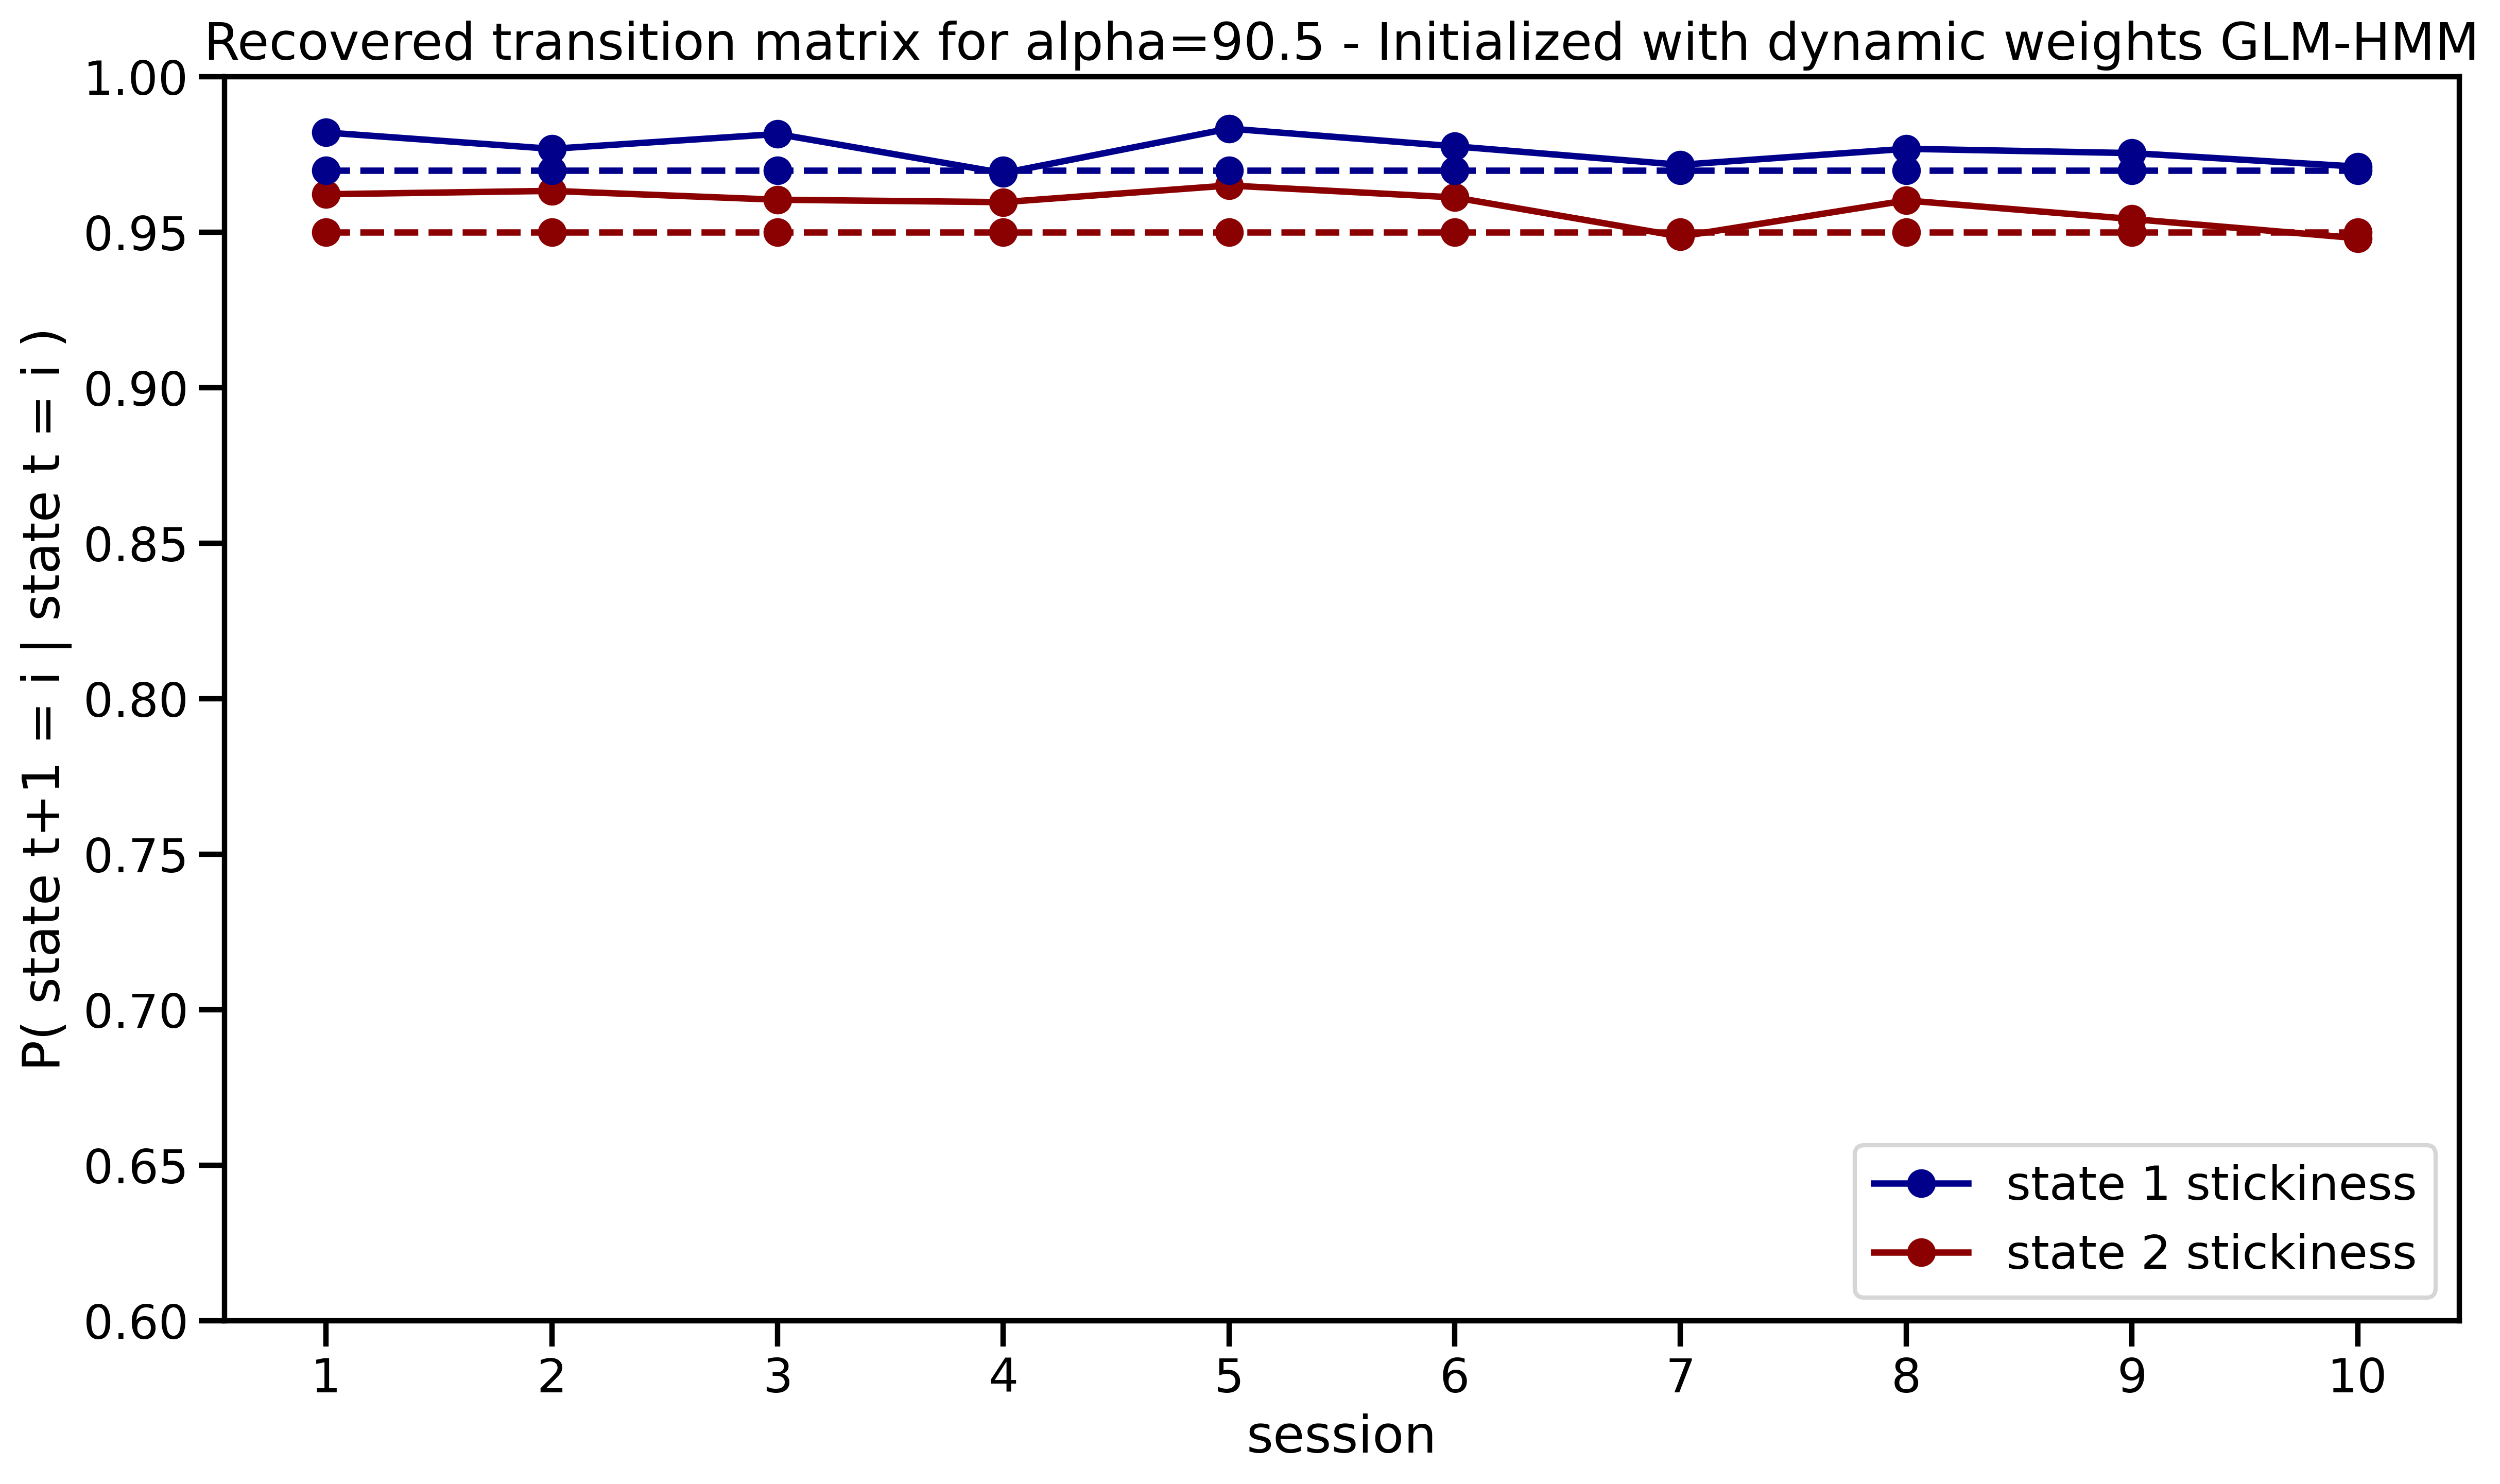

In [26]:
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_weights(oldW[10], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for alpha={np.round(alphaList[10],1)} - Initialized with dynamic weights GLM-HMM', save_fig=False)
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_transition_matrix_stickiness(oldP[10], sessInd, axes, trueP=trueP, title=f'Recovered transition matrix for alpha={np.round(alphaList[10],1)} - Initialized with dynamic weights GLM-HMM', save_fig=False)

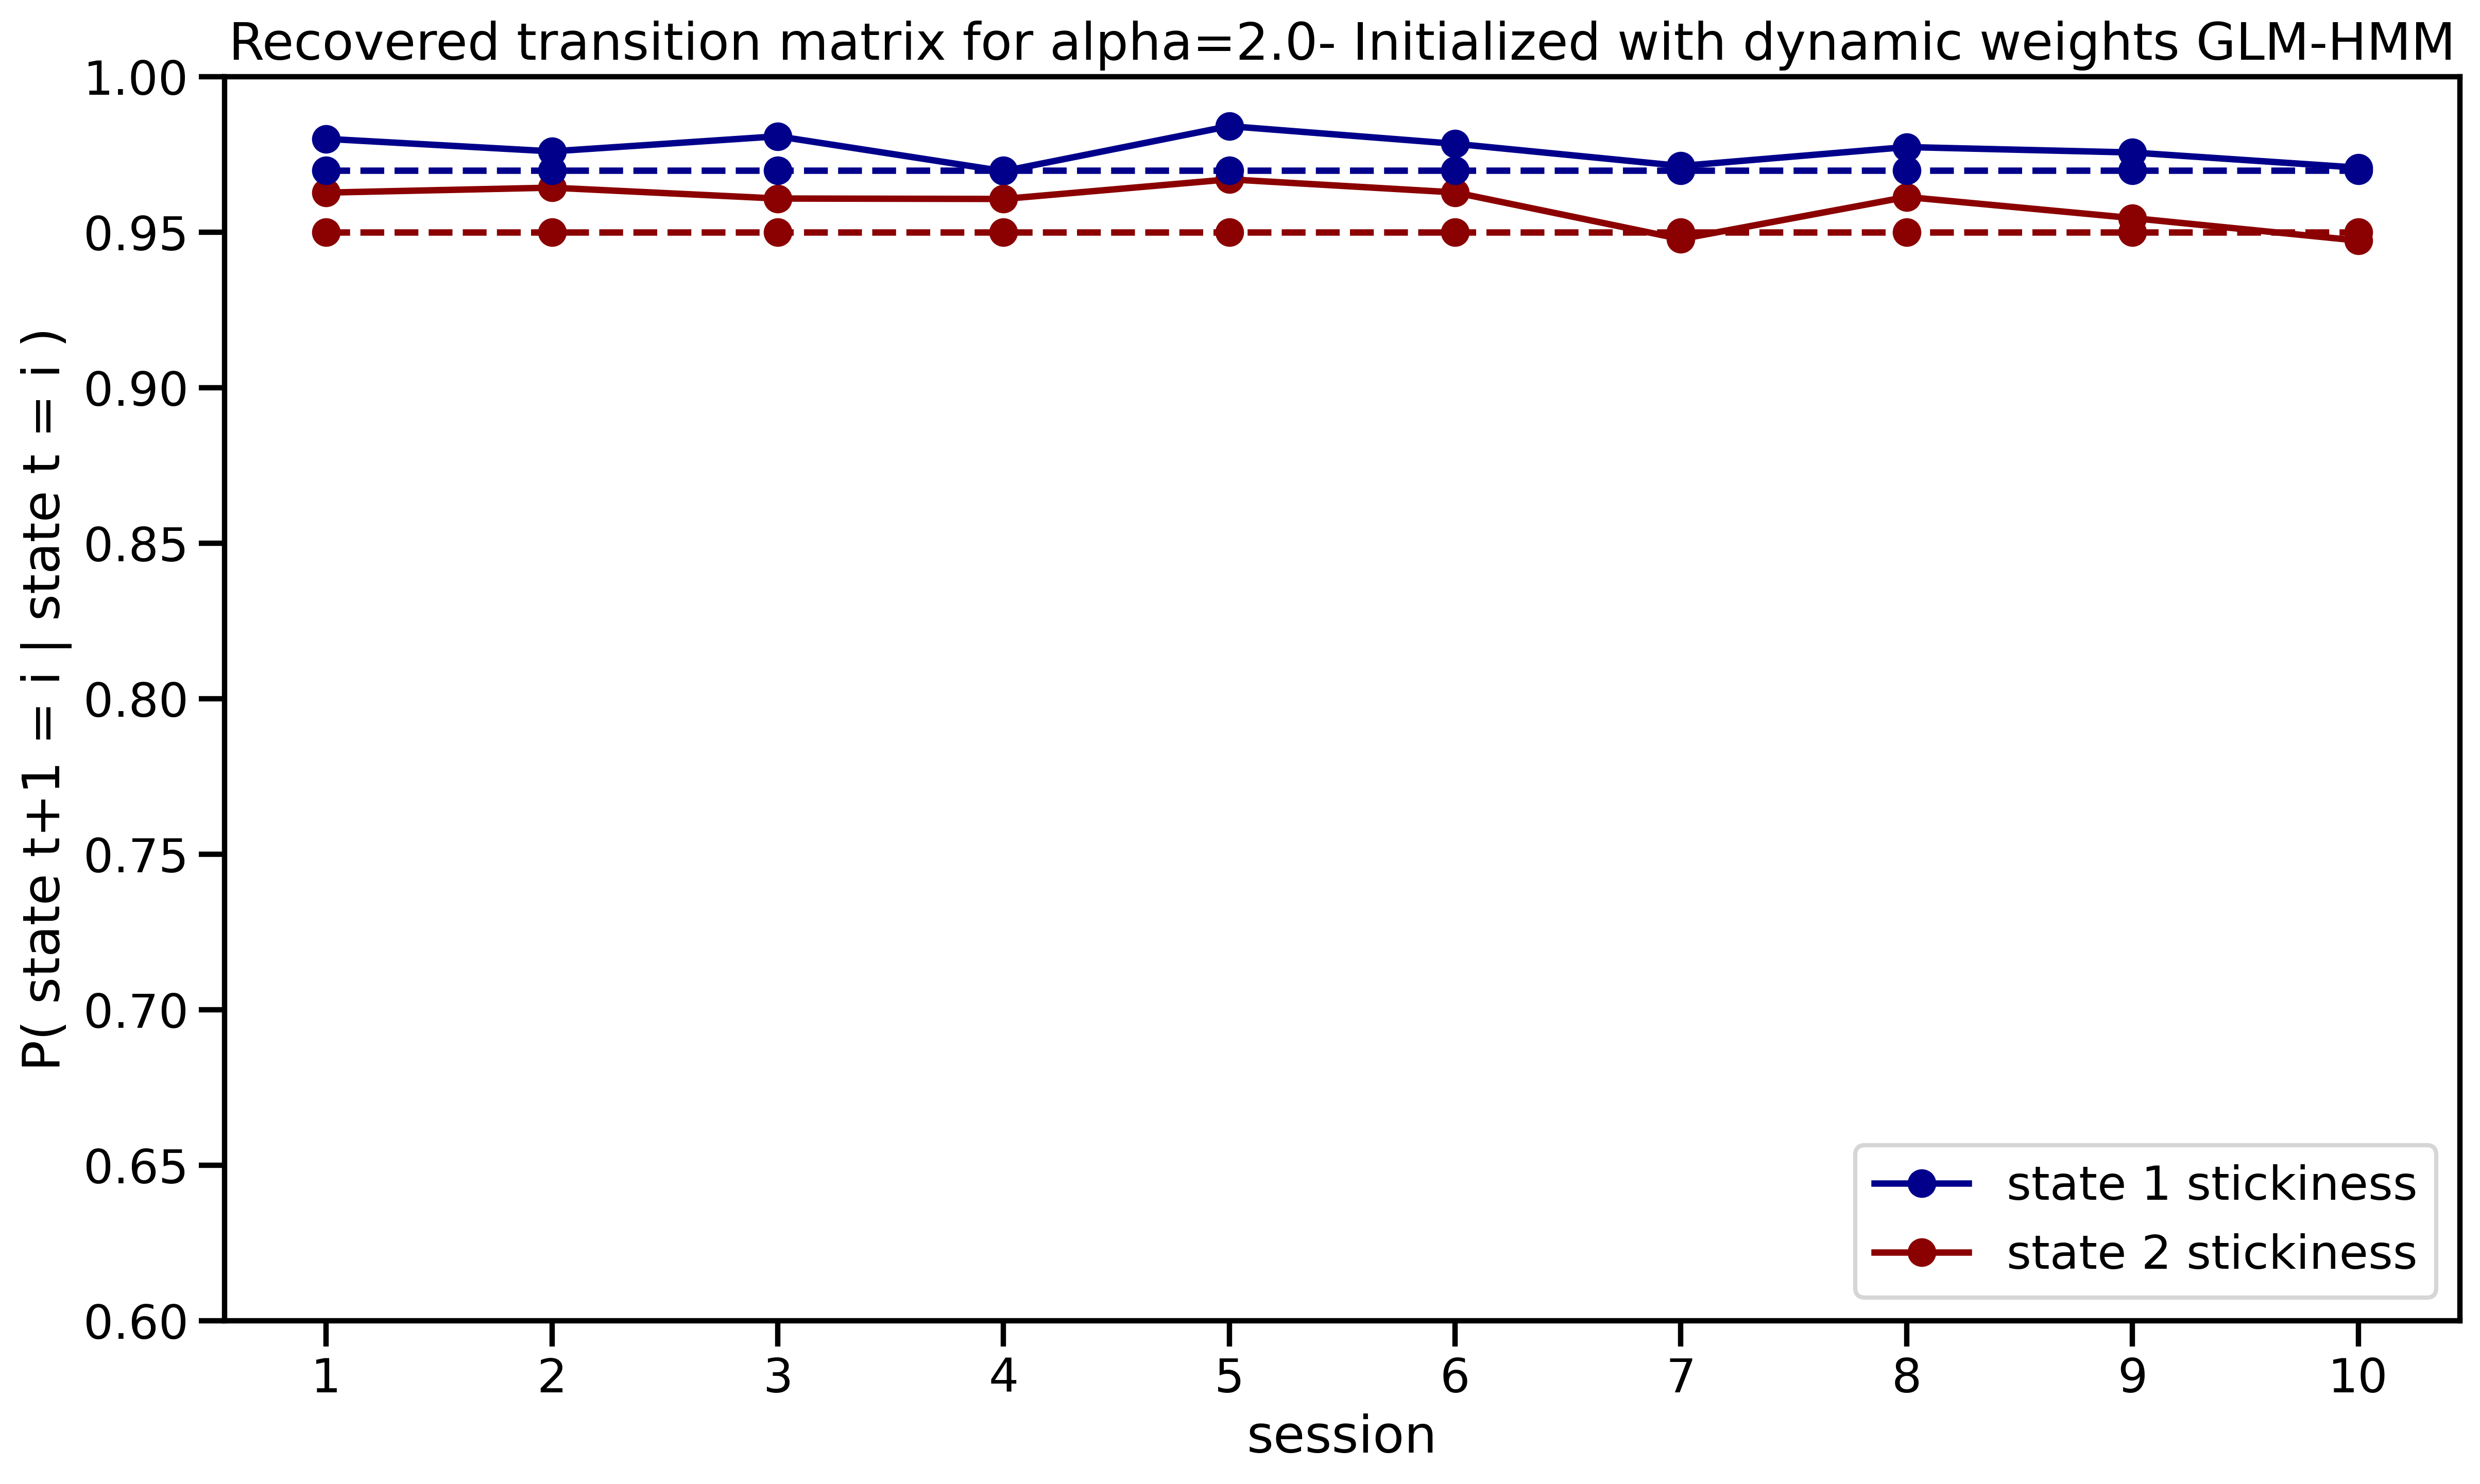

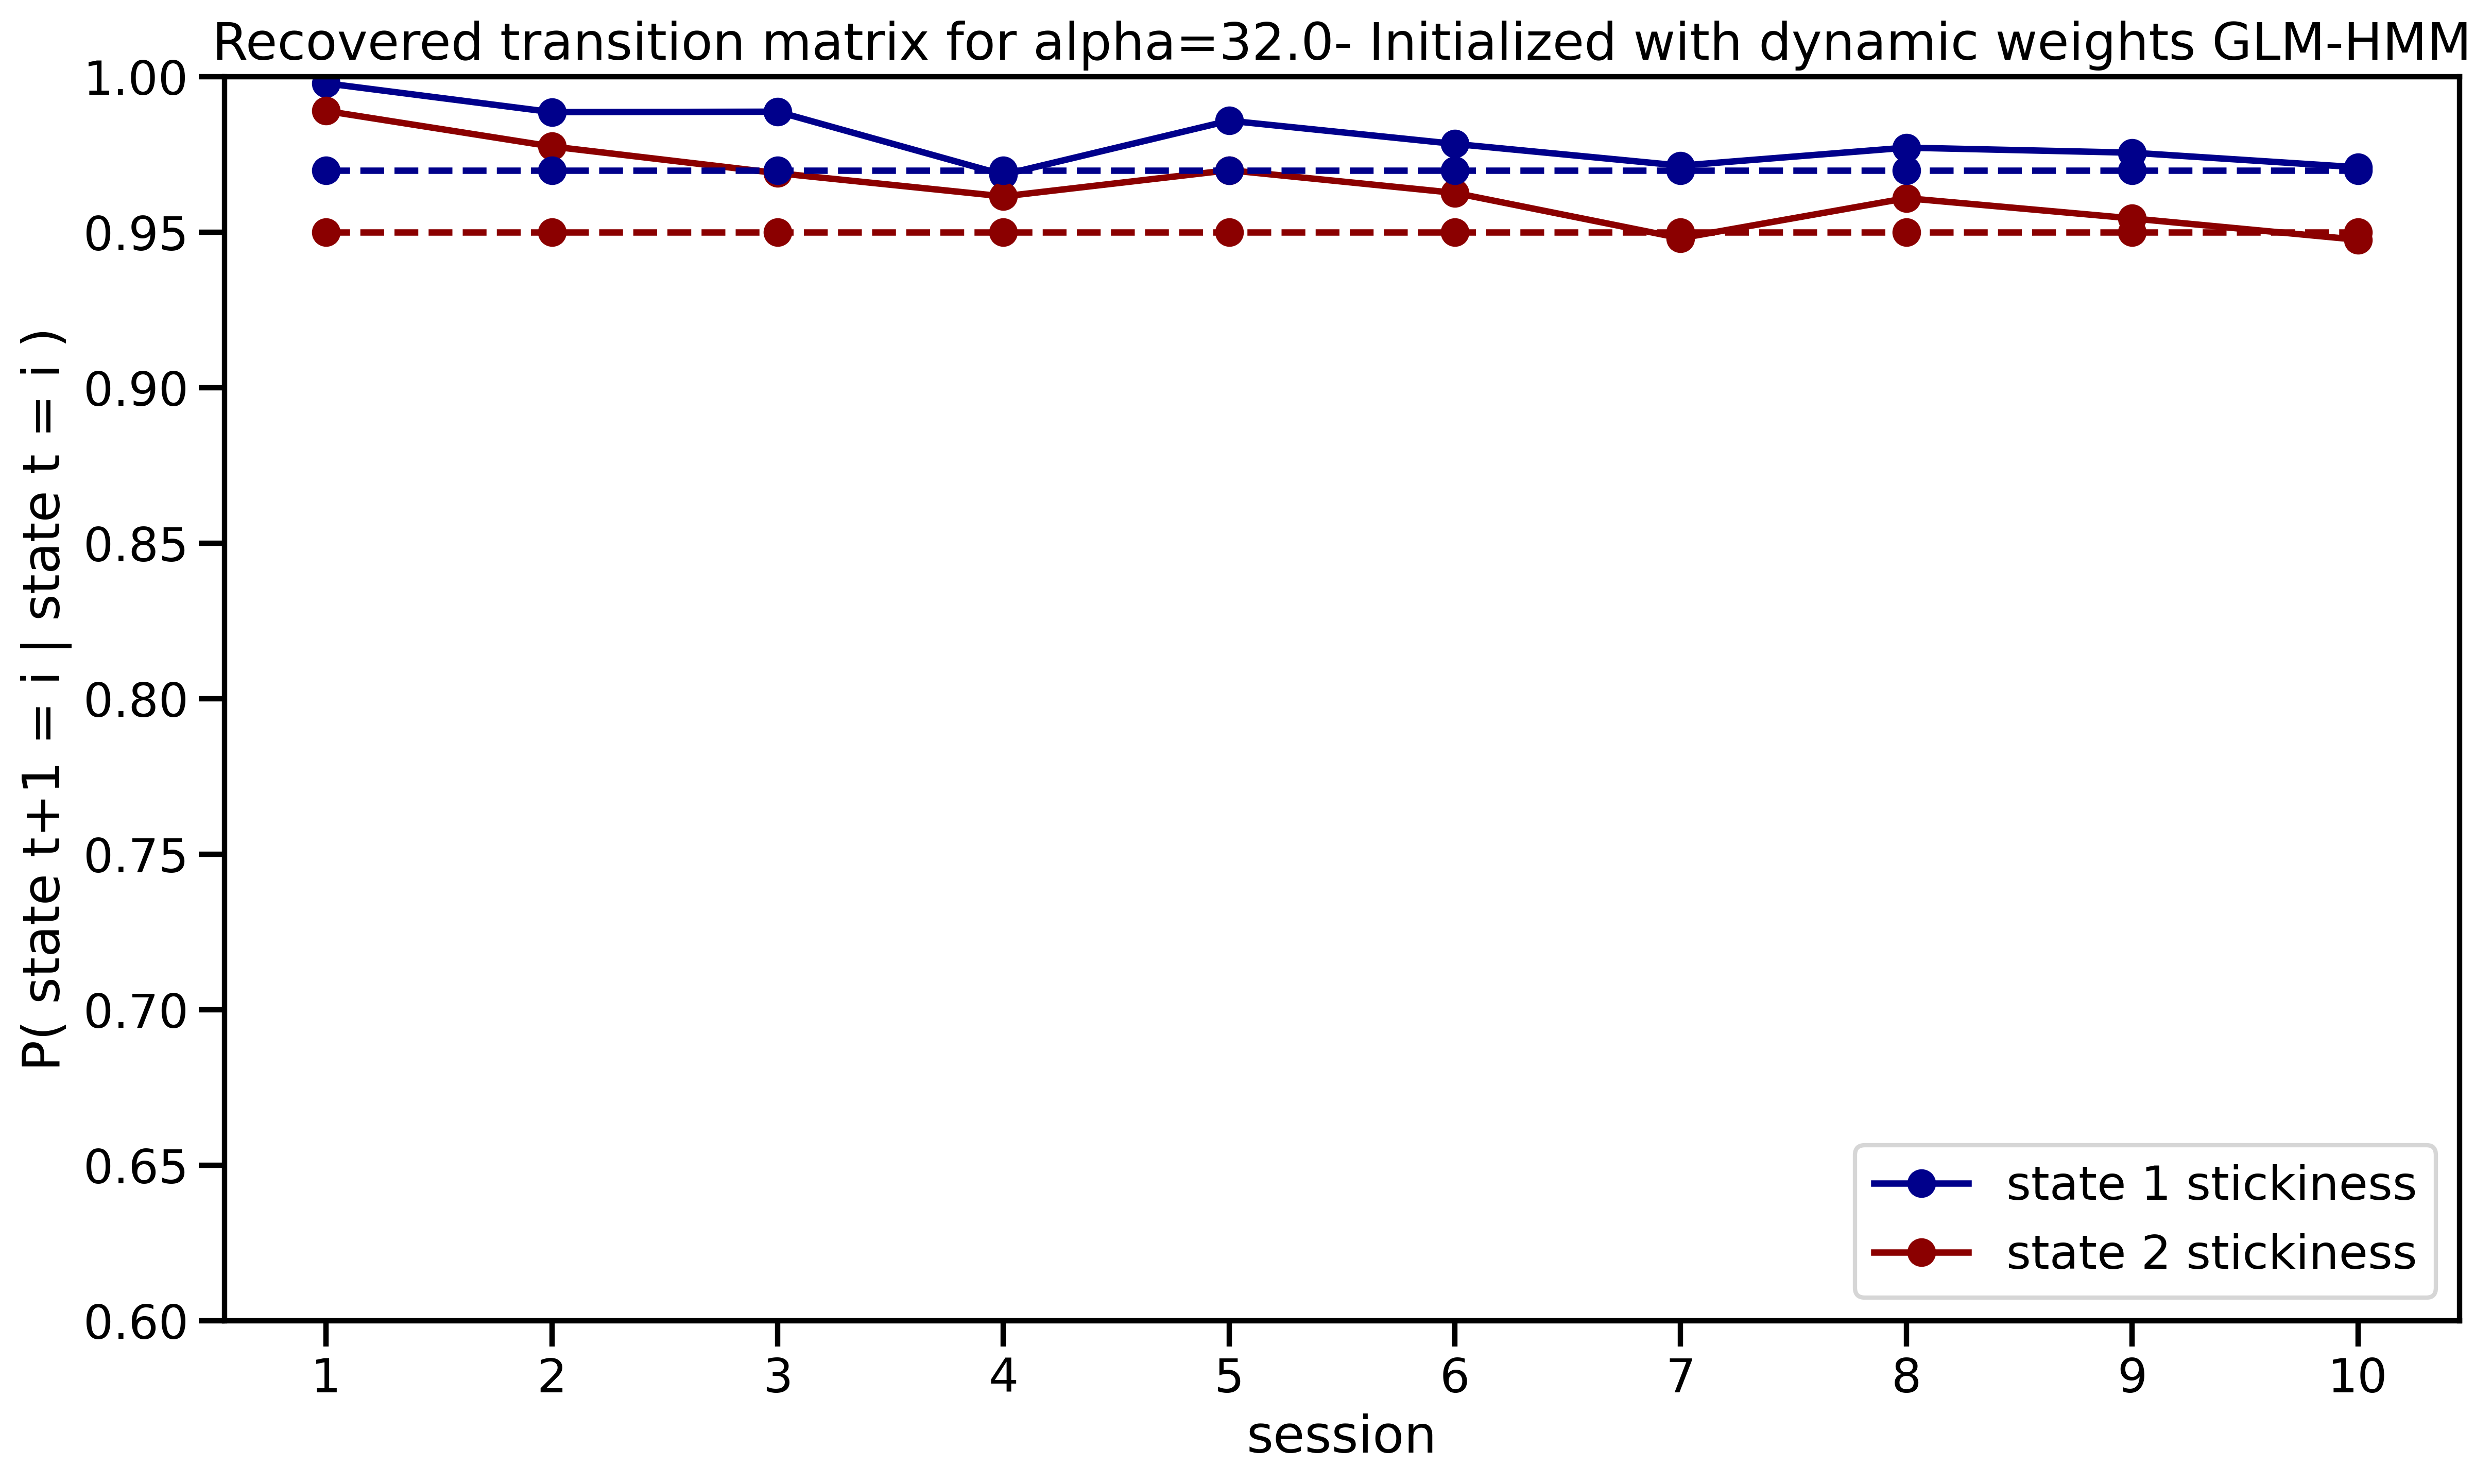

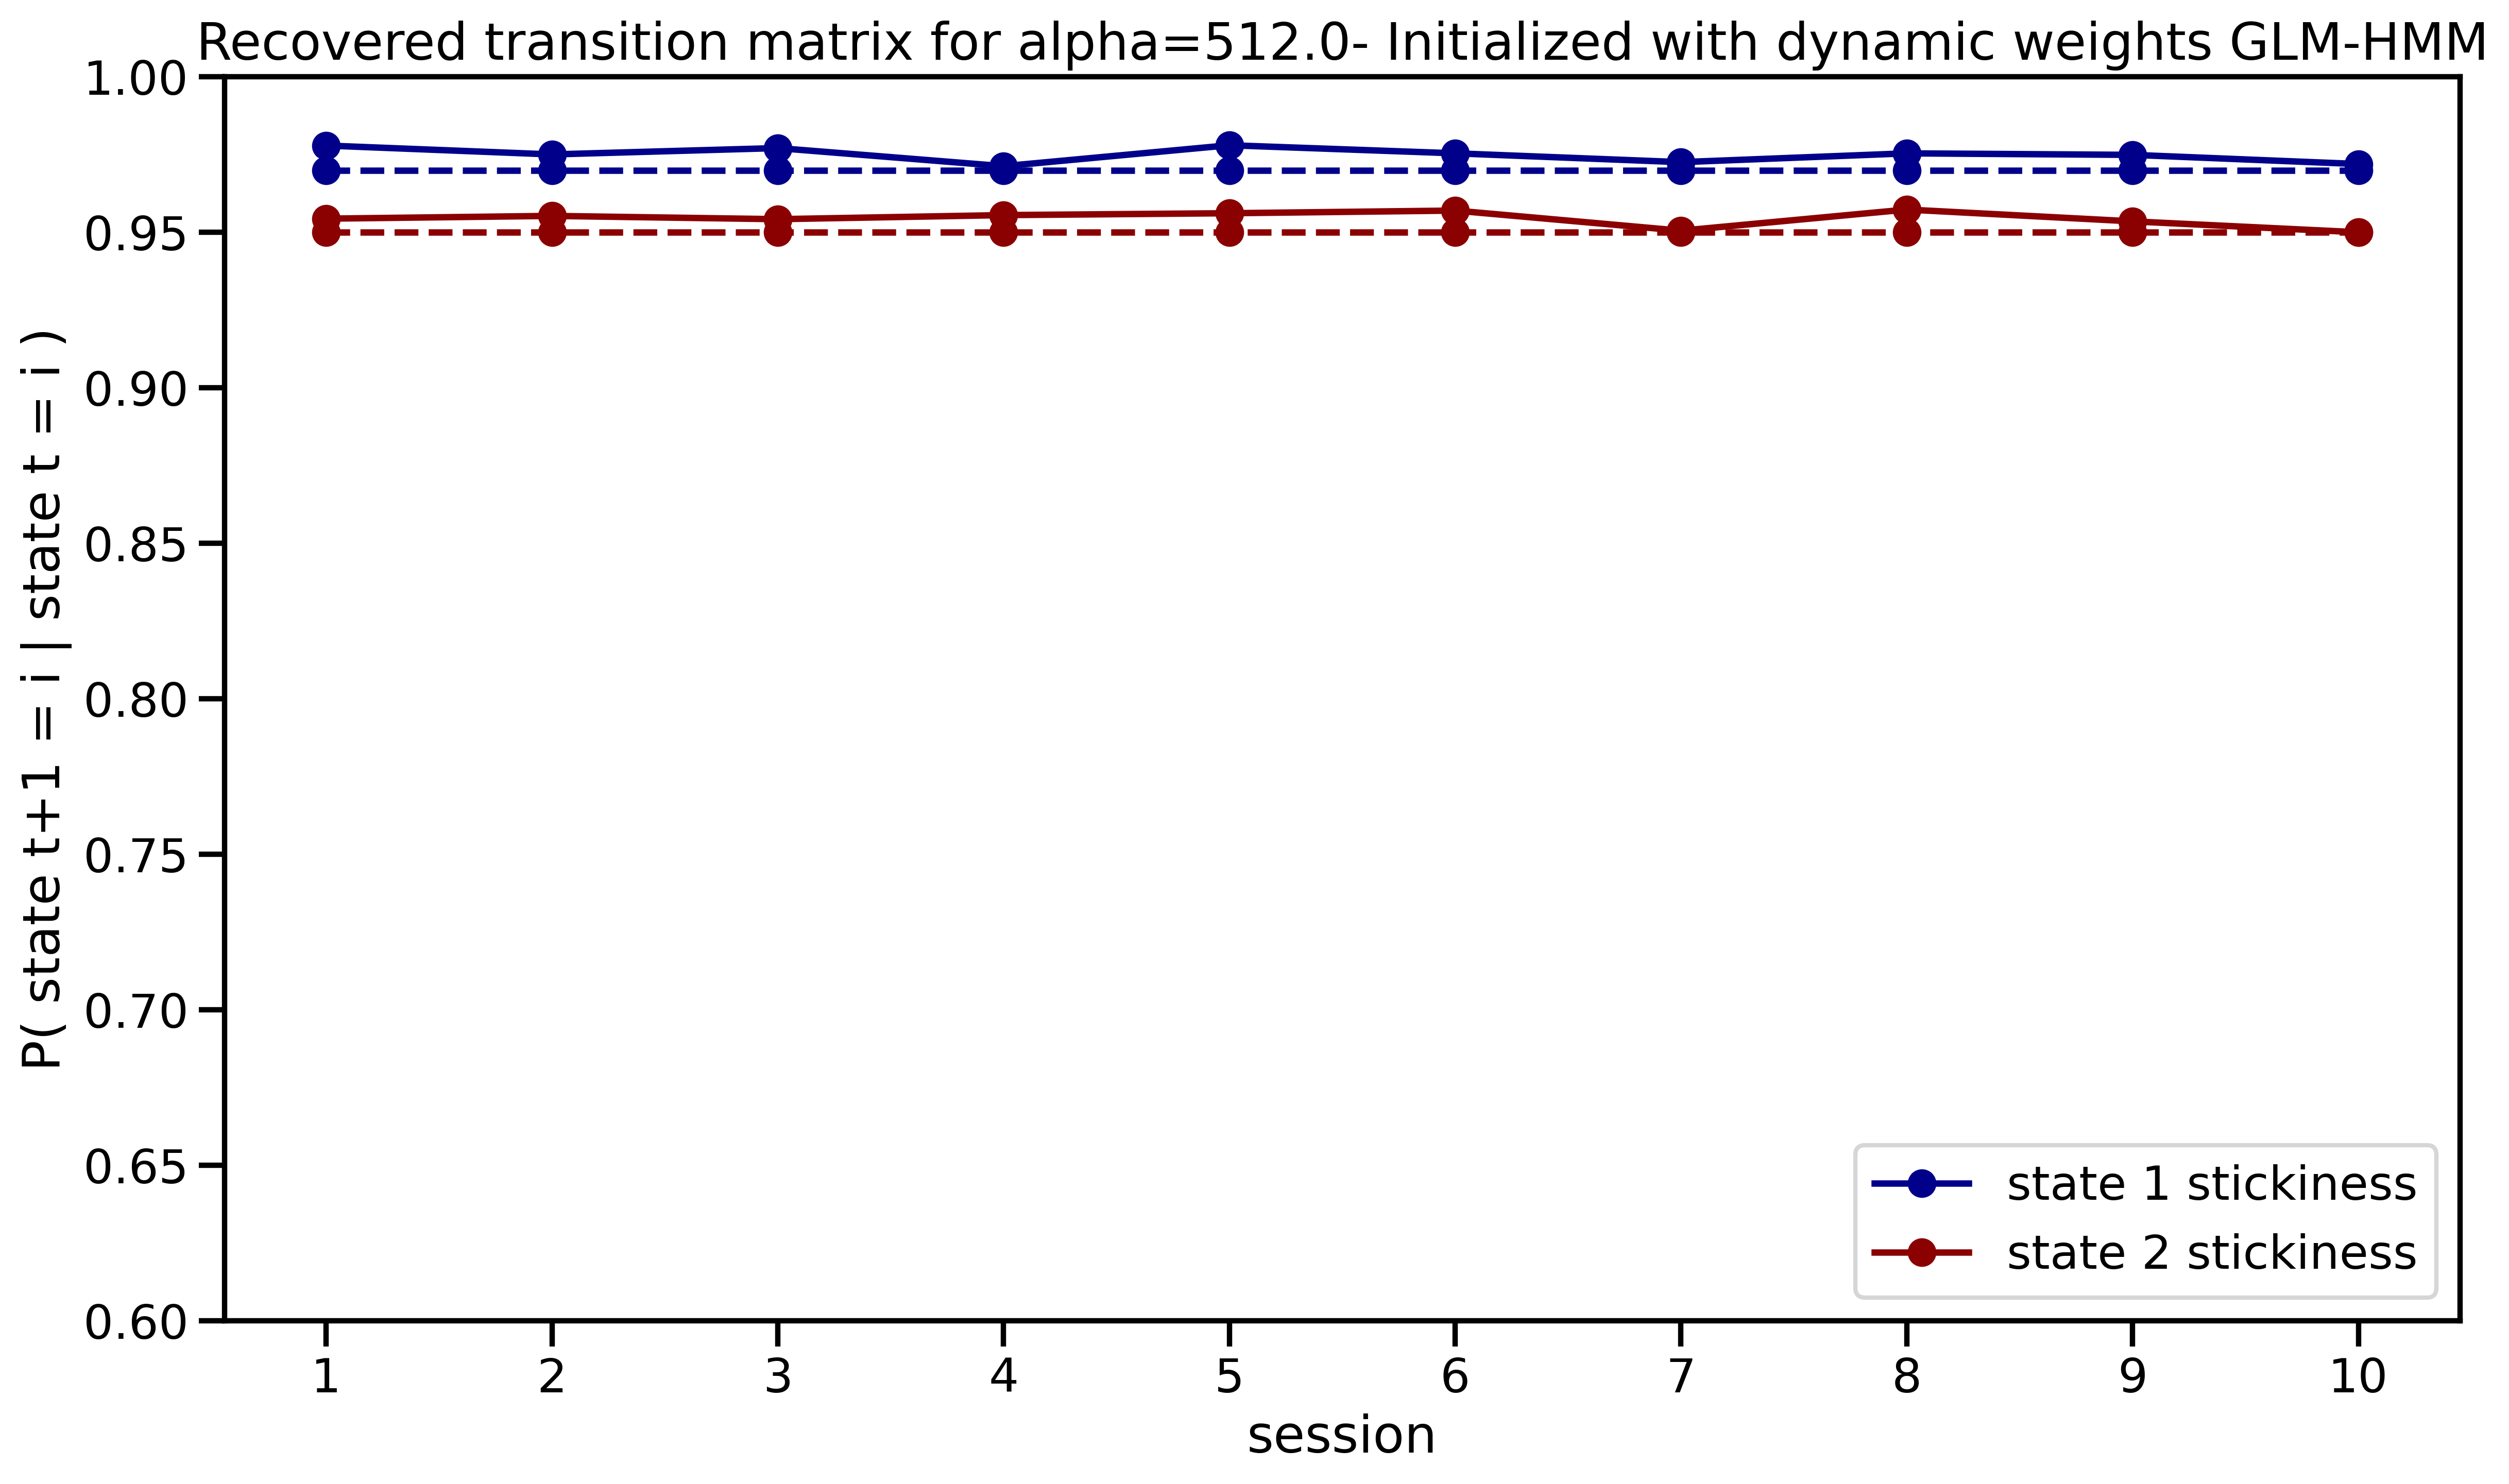

In [67]:
# CHECK FIT TRANSITION MATRIX AND WEIGHTS
for indAlpha in [0,4,8]: #range(5,len(alphaList)-3):
    # fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
    # plotting_weights(oldW[indAlpha], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for alpha={np.round(alphaList[indAlpha],1)} - Initialized with dynamic weights GLM-HMM', save_fig=False)
    fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
    plotting_transition_matrix_stickiness(allP[indAlpha], sessInd, axes, trueP=trueP, title=f'Recovered transition matrix for alpha={np.round(alphaList[indAlpha],1)}- Initialized with dynamic weights GLM-HMM', save_fig=False)

### Transition matrix is different for each session

In [10]:
# True Transition Matrix
ourP = np.zeros((2,2))
ourP[0,0]=0.97
ourP[0,1]=0.03
ourP[1,0]=.05
ourP[1,1]=.95
print("True Transition Matrix P")
print(ourP)

# trueP = np.zeros((N,K,K))
# for sess in range(0,S):
#     a = np.random.dirichlet(np.ones((K))+(K)*ourP[0])
#     b = np.random.dirichlet(np.ones((K))+(K)*ourP[1])
#     for t in range(0,T):
#         trueP[sess*T+t,0] = a
#         trueP[sess*T+t,1] = b
#np.save(f'../data/M2-TrueP-random', trueP)
trueP = np.load('../data/M2-TrueP-random.npy')

print(trueP[0])

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]
[[0.72031301 0.27968699]
 [0.02656842 0.97343158]]


In [14]:
dGLMHMM = dglm_hmm2.dGLM_HMM2(N,K,D,C)
# x, y, z = dGLMHMM.simulate_data(trueW, trueP, sessInd, save=True, title='randomP-sim', pi0=0.5)
x = np.load('../data/M2_randomP-simX.npy')
y = np.load('../data/M2_randomP-simY.npy')
z = np.load('../data/M2_randomP-simZ.npy')

2874
